# PREDICTING DEPRESSION SYMPTOMS FROM DISCORD CHAT MESSAGES USING AI MEDICAL CHATBOTS

v.duvvuri@northeastern.edu (Venkata Duvvuri) 

qiguan@ucdavis.edu (Qihan Guan)

daddala.s@northeastern.edu (Swetha Jayanth) 

mitch@jeevahealth.ai (Mitchel Harris)

sudhakar@jeevahealth.ai (Sudhakar Kaushik)


## Import Libraries and Data

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/Research Group'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Research Group


In [ ]:
# Uncomment to install dependencies
# !pip install texthero -U
# !pip install gensim
# !pip install pyLDAvis==2.1.2

In [5]:
# data manipulation
import pandas as pd
import numpy as np
import io 

# plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.colors as mcolors

# natural language processing
import re
import nltk
from nltk.tokenize import TweetTokenizer
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import texthero as hero 
from texthero import preprocessing
from textblob import TextBlob 
from gensim.models import LdaModel
from gensim import models
from gensim import corpora
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS

# model building 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# neural network 
%tensorflow_version 1.x #use version 1.x to use predict_classes function
import tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# model evaluation
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x #use version 1.x to use predict_classes function`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [6]:
df=pd.read_csv('AllTagged.csv')

In [7]:
df.head()

,ID,AuthorID,Author,Date,Content,Words,"Change in appetite, losing or gaining weight",Sleeping too much or not sleeping well (insomnia),Fatigue and low energy most days,"Feeling worthless, guilty, and hopeless","An inability to focus and concentrate that may interfere with daily tasks at home, work, or school",Movements that are unusually slow or agitated (a change which is often noticeable to others),Thinking about death and dying; suicidal ideation or suicide attempts,None
0,1,4.560000e+17,Deleted User#0000,43630.77639,**List of International Suicide Hotlines**\n``...,72,N,N,N,N,N,N,N,Y
1,2,4.560000e+17,Deleted User#0000,43630.78611,"Hello, if you're depressed, being self-depreca...",56,N,N,N,Y,N,N,Y,N
2,3,4.680000e+17,angel?#5373,43630.84306,Please note that we are not professionals. Th...,61,N,N,N,N,N,N,N,Y
3,4,5.450000e+17,Sease#2410,43630.84514,yeah and people who just want attention don't ...,36,N,N,N,N,N,N,N,Y
4,5,3.030000e+17,Emma/Blue#2035,43630.85347,Just a small vent my arm hurts so much i know ...,41,N,N,N,Y,Y,Y,N,N


In [8]:
df=df.dropna()

In [9]:
list(df)

['ID',
 'AuthorID',
 'Author',
 'Date',
 'Content',
 'Words',
 'Change in appetite, losing or gaining weight',
 'Sleeping too much or not sleeping well (insomnia)',
 'Fatigue and low energy most days',
 'Feeling worthless, guilty, and hopeless',
 'An inability to focus and concentrate that may interfere with daily tasks at home, work, or school',
 'Movements that are unusually slow or agitated (a change which is often noticeable to others)',
 'Thinking about death and dying; suicidal ideation or suicide attempts',
 'None']

In [10]:
df.isnull().sum()

ID                                                                                                    0
AuthorID                                                                                              0
Author                                                                                                0
Date                                                                                                  0
Content                                                                                               0
Words                                                                                                 0
Change in appetite, losing or gaining weight                                                          0
Sleeping too much or not sleeping well (insomnia)                                                     0
Fatigue and low energy most days                                                                      0
Feeling worthless, guilty, and hopeless                         

In [11]:
df['None'] = df['None'].map({'Y': 1, 'N': 0})
df['Change in appetite, losing or gaining weight']=df['Change in appetite, losing or gaining weight'].map({'Y': 1, 'N': 0})
df['Sleeping too much or not sleeping well (insomnia)']=df['Sleeping too much or not sleeping well (insomnia)'].map({'Y': 1, 'N': 0})
df['Fatigue and low energy most days']=df['Fatigue and low energy most days'].map({'Y': 1, 'N': 0})
df['Feeling worthless, guilty, and hopeless']=df['Feeling worthless, guilty, and hopeless'].map({'Y': 1, 'N': 0})
df['An inability to focus and concentrate that may interfere with daily tasks at home, work, or school']=df['An inability to focus and concentrate that may interfere with daily tasks at home, work, or school'].map({'Y': 1, 'N': 0})
df['Movements that are unusually slow or agitated (a change which is often noticeable to others)']=df['Movements that are unusually slow or agitated (a change which is often noticeable to others)'].map({'Y': 1, 'N': 0})
df['Thinking about death and dying; suicidal ideation or suicide attempts']=df['Thinking about death and dying; suicidal ideation or suicide attempts'].map({'Y': 1, 'N': 0})

In [12]:
df.rename(columns={"Change in appetite, losing or gaining weight": "symp_one", "Sleeping too much or not sleeping well (insomnia)": "symp_two",
                  "Fatigue and low energy most days":'symp_three','Feeling worthless, guilty, and hopeless':'symp_four',
                  'An inability to focus and concentrate that may interfere with daily tasks at home, work, or school':'symp_five',
                  'Movements that are unusually slow or agitated (a change which is often noticeable to others)':'symp_six',
                  'Thinking about death and dying; suicidal ideation or suicide attempts':'symp_seven'},inplace=True)

In [13]:
df.head(10)

,ID,AuthorID,Author,Date,Content,Words,symp_one,symp_two,symp_three,symp_four,symp_five,symp_six,symp_seven,None
0,1,4.560000e+17,Deleted User#0000,43630.77639,**List of International Suicide Hotlines**\n``...,72,0,0,0,0.0,0,0,0.0,1.0
1,2,4.560000e+17,Deleted User#0000,43630.78611,"Hello, if you're depressed, being self-depreca...",56,0,0,0,1.0,0,0,1.0,0.0
2,3,4.680000e+17,angel?#5373,43630.84306,Please note that we are not professionals. Th...,61,0,0,0,0.0,0,0,0.0,1.0
3,4,5.450000e+17,Sease#2410,43630.84514,yeah and people who just want attention don't ...,36,0,0,0,0.0,0,0,0.0,1.0
4,5,3.030000e+17,Emma/Blue#2035,43630.85347,Just a small vent my arm hurts so much i know ...,41,0,0,0,1.0,1,1,0.0,0.0
5,6,3.030000e+17,Emma/Blue#2035,43630.86597,They do where I live I had to call 911 before ...,19,0,0,0,0.0,0,0,0.0,1.0
6,7,3.030000e+17,Emma/Blue#2035,43630.86667,I don‚Äôt want to seem like I‚Äôm saying no to...,22,0,0,0,0.0,0,0,0.0,1.0
7,8,5.290000e+17,‚ô°ghost girl#4650,43630.86806,"damn it seems really bad, and your parents hav...",17,0,0,0,0.0,0,0,0.0,1.0
8,9,3.030000e+17,Emma/Blue#2035,43630.86944,They don‚Äôt have the money and don‚Äôt want t...,17,0,0,0,0.0,0,0,0.0,1.0
9,10,3.030000e+17,Emma/Blue#2035,43630.87292,I get a lot of shooting pains from my nerves l...,28,0,0,0,0.0,0,0,0.0,1.0


In [14]:
categorical_features=df.select_dtypes(include=['object'])
categorical_features

,Author,Date,Content,Words
0,Deleted User#0000,43630.77639,**List of International Suicide Hotlines**\n``...,72
1,Deleted User#0000,43630.78611,"Hello, if you're depressed, being self-depreca...",56
2,angel?#5373,43630.84306,Please note that we are not professionals. Th...,61
3,Sease#2410,43630.84514,yeah and people who just want attention don't ...,36
4,Emma/Blue#2035,43630.85347,Just a small vent my arm hurts so much i know ...,41
...,...,...,...,...
23989,AfonsoHackers#6969,44071.59167,> And it‚Äôs just getting so annoying and I‚Äô...,26
23990,sluttywhoreü¶¶#3156,44071.59236,And I‚Äôm mixed so I get called the n word wit...,18
23991,SAD BHABHIE.#3636,44071.59236,> @SAD BHABHIE. oof that's a good thing I supp...,50
23992,SAD BHABHIE.#3636,44071.59236,> And I‚Äôm mixed so I get called the n word w...,21


## Cleaning Text Data

Tokenize text

In [15]:
tt = TweetTokenizer()
tokens = df['Content'].apply(tt.tokenize)
print(tokens)

0        [*, *, List, of, International, Suicide, Hotli...
1        [Hello, ,, if, you're, depressed, ,, being, se...
2        [Please, note, that, we, are, not, professiona...
3        [yeah, and, people, who, just, want, attention...
4        [Just, a, small, vent, my, arm, hurts, so, muc...
                               ...                        
23989    [>, And, it, ‚, Äôs, just, getting, so, annoyi...
23990    [And, I, ‚, Äôm, mixed, so, I, get, called, th...
23991    [>, @SAD, BHABHIE, ., oof, that's, a, good, th...
23992    [>, And, I, ‚, Äôm, mixed, so, I, get, called,...
23993    [>, Yeah, I, ‚, Äôve, ignored, it, for, 5, yea...
Name: Content, Length: 23978, dtype: object


Cleaning the Content with multiple commas

In [16]:
df['Content']=df['Content'].apply(lambda x: x.split(',,')[0])


In [17]:
df['Content']=df['Content'].apply(lambda x: x.split(',,,')[0])


Expand contractions; Lowercase the reviews; Remove digits and words containing digits; Remove punctuations

In [18]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Content']=df['Content'].apply(lambda x:expand_contractions(x))

Lowercase the comments

In [19]:
df['Content']=df['Content'].apply(lambda x: x.lower())


Remove digits and words containing digits


In [20]:
df['Content']=df['Content'].apply(lambda x: re.sub('\w*\d\w*','', x))


Remove Punctuations


In [21]:
df['Content']=df['Content'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))


Removing Extra Spaces

In [22]:
df['Content']=df['Content'].apply(lambda x: re.sub(' +',' ',x))


Looking at the text after cleaning

In [23]:
for index,text in enumerate(df['Content'][35:40]):
  print('content %d:\n'%(index+1),text)

content 1:
 not enough apparently if you were helping yourself over span of several years you would be feeling a lot better
content 2:
 i do try to do it but when everyone fucking criticizes you on every fucking small detail it makes it worse ok
content 3:
 so i‚äôve been trying and i‚äôve tried and tried and tried so don‚äôt act like i‚äôm not trying to get out of this shit
content 4:
 the misconception of trying is that people think trying is enough if it does not work it is hopeless
you do not try to be a better person you have to actively be a better person until it is internalized to the point where you do not even have to try you are by default
same with gym for example you do not try to go to gym lazily and skipping few days and when you do not achieve your goal you will say i tried it is mostly crap
trying never works because it is often forced ungenuine and tries to adapt to your comfort instead of something fundamentally changing and actively done
content 5:
 so i will not sa

Removing Stopwords and Lemmatization

In [24]:
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['Content']=df['Content'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


The final dataset 

In [25]:
df

,ID,AuthorID,Author,Date,Content,Words,symp_one,symp_two,symp_three,symp_four,symp_five,symp_six,symp_seven,None
0,1,4.560000e+17,Deleted User#0000,43630.77639,list international suicide hotlines \n argenti...,72,0,0,0,0.0,0,0,0.0,1.0
1,2,4.560000e+17,Deleted User#0000,43630.78611,hello depressed selfdeprecate thing bad talk a...,56,0,0,0,1.0,0,0,1.0,0.0
2,3,4.680000e+17,angel?#5373,43630.84306,note professional community try help good abil...,61,0,0,0,0.0,0,0,0.0,1.0
3,4,5.450000e+17,Sease#2410,43630.84514,yeah people want attention actually listen peo...,36,0,0,0,0.0,0,0,0.0,1.0
4,5,3.030000e+17,Emma/Blue#2035,43630.85347,small vent arm hurt know need doctor can‚äôt a...,41,0,0,0,1.0,1,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23989,23995,3.110000e+17,AfonsoHackers#6969,44071.59167,it‚äôs get annoying i‚äôm \n sluttywhoreü¶¶...,26,0,0,0,0.0,0,0,0.0,1.0
23990,23996,6.460000e+17,sluttywhoreü¶¶#3156,44071.59236,i‚äôm mix call n word hard r year,18,0,0,0,1.0,0,0,0.0,0.0
23991,23997,7.240000e+17,SAD BHABHIE.#3636,44071.59236,sad bhabhie oof good thing suppose mean find...,50,0,0,0,0.0,0,0,0.0,1.0
23992,23998,7.240000e+17,SAD BHABHIE.#3636,44071.59236,i‚äôm mixed call n word hard r year \n slutt...,21,0,0,0,1.0,0,0,0.0,0.0


Split the data into depression diagnosis training set and validation set\
Use 80% for symptom model training and validation, and 20% for depression diagnostic validation

In [26]:
df_train = df.sample(frac=0.8, random_state=1000)
df_test = df.drop(df_train.index)

In [27]:
df_train.shape

(19182, 14)

In [28]:
df_test.shape

(4796, 14)

## Exploratory Data Analysis

Distribution of text length

Text(0, 0.5, 'Frequency of Text Length')

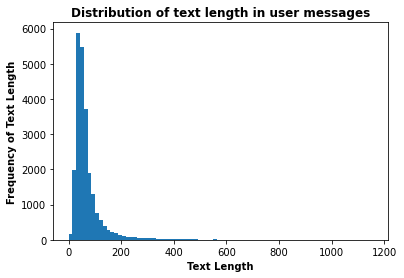

In [29]:
# add a new column, the length of the content column
df['length']=df['Content'].apply(len)

#distribution of length
df['length'].plot.hist(bins=80)
plt.title('Distribution of text length in user messages', fontweight='bold')
plt.xlabel("Text Length", fontweight='bold')
plt.ylabel("Frequency of Text Length", fontweight='bold')

Distribution of length of corresponding text for each symptom

Text(0, 0.5, 'Count')

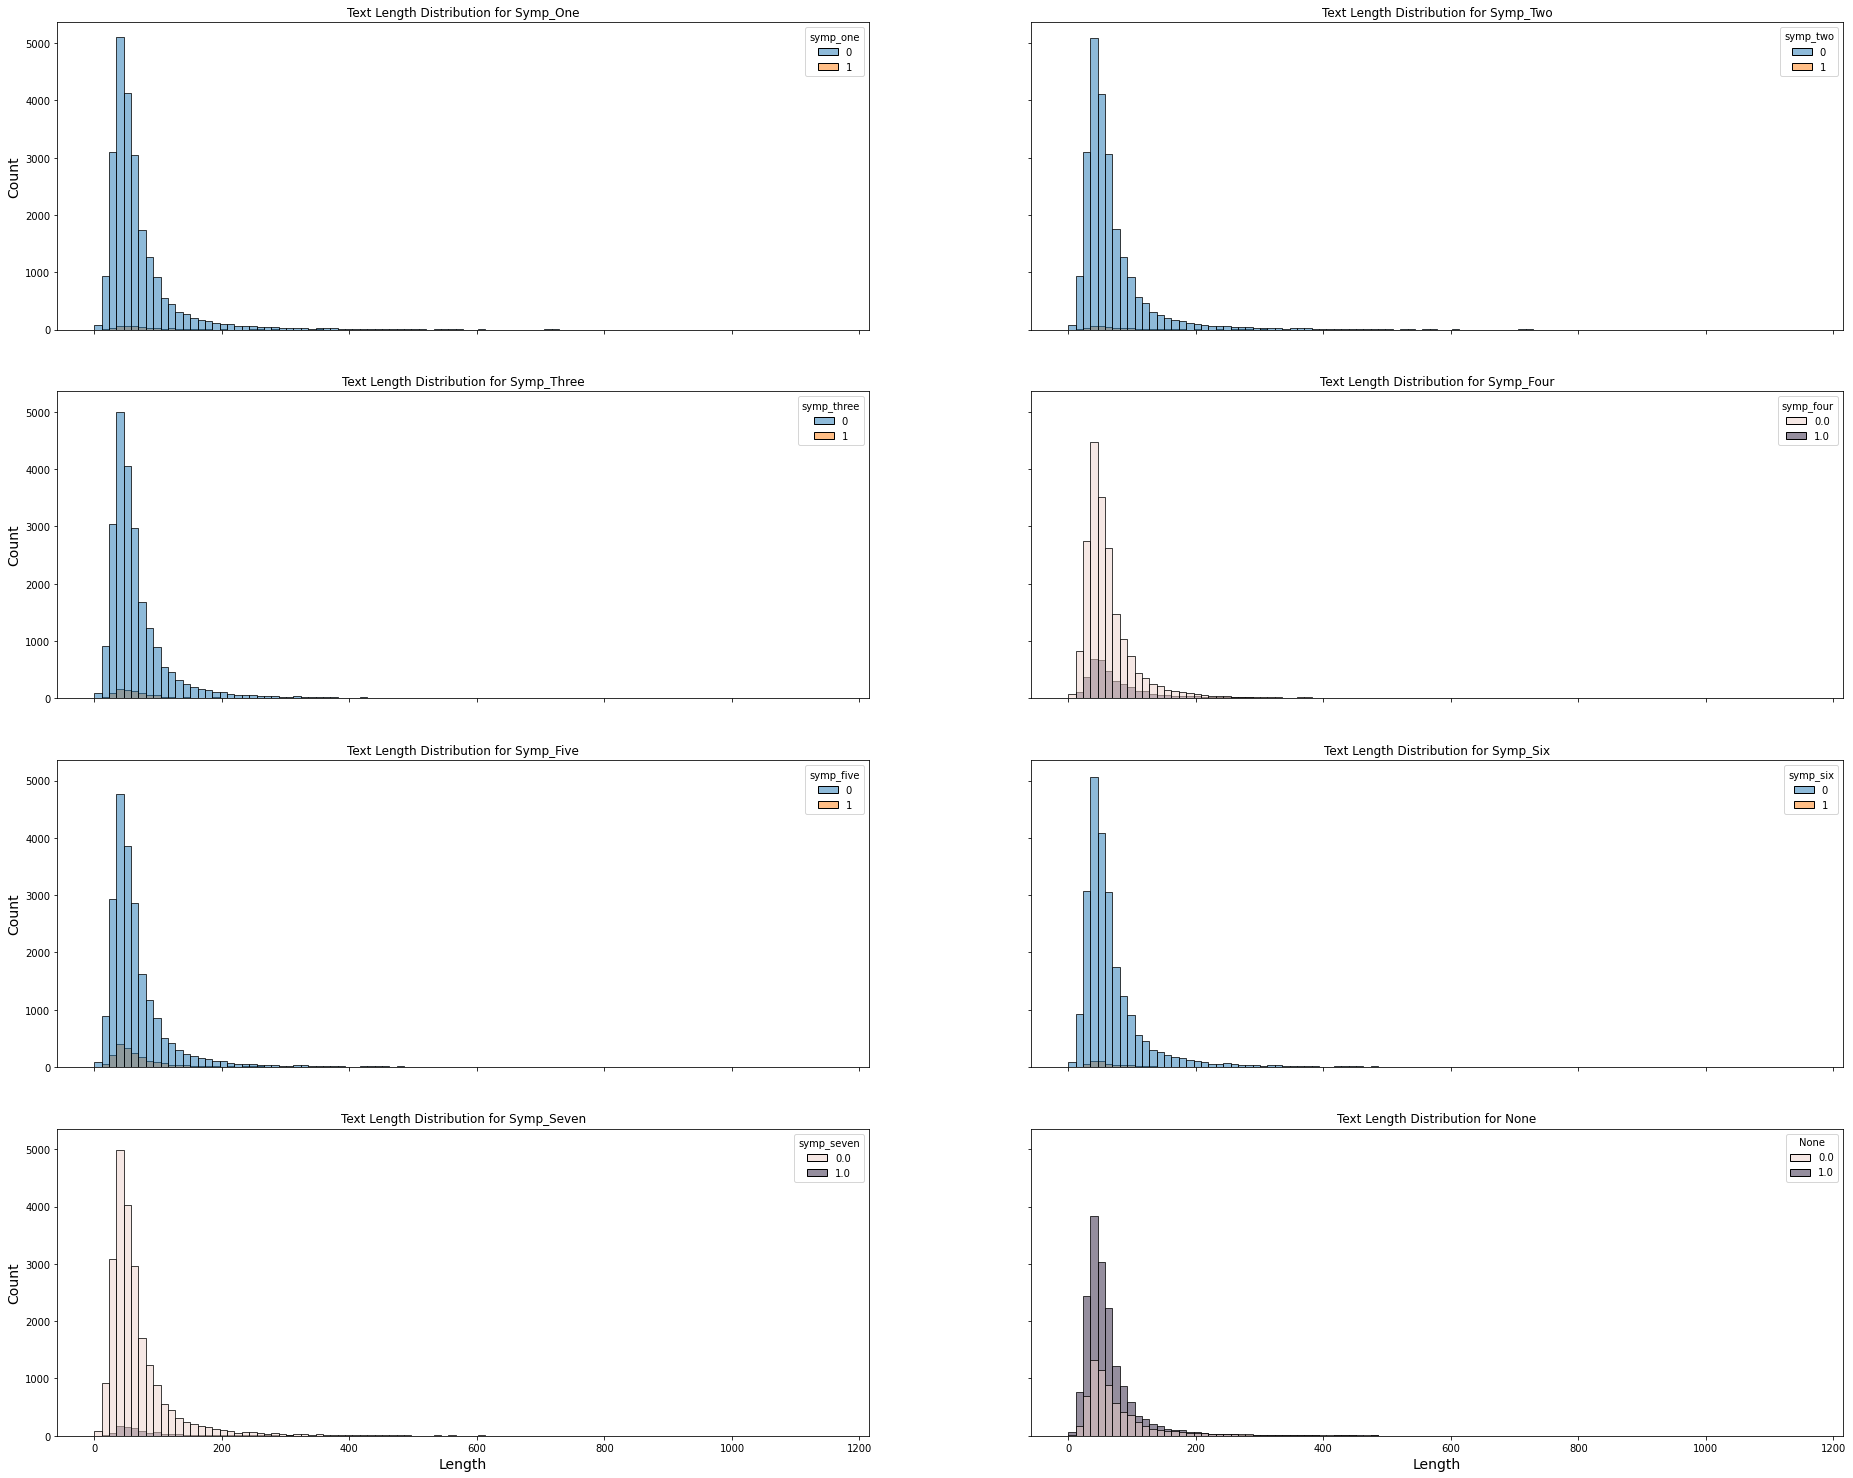

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(32,26), sharex=True, sharey=True)
sns.histplot(data=df, x="length", hue="symp_one", bins=100, ax = axes[0,0])
axes[0,0].set_title("Text Length Distribution for Symp_One")
axes[0,0].set_xlabel("Length", fontsize = 14)
axes[0,0].set_ylabel("Count", fontsize = 14)

sns.histplot(data=df, x="length", hue="symp_two", bins=100, ax = axes[0,1])
axes[0,1].set_title("Text Length Distribution for Symp_Two")
axes[0,1].set_xlabel("Length", fontsize = 14)
axes[0,1].set_ylabel("Count", fontsize = 14)

sns.histplot(data=df, x="length", hue="symp_three", bins=100, ax = axes[1,0])
axes[1,0].set_title("Text Length Distribution for Symp_Three")
axes[1,0].set_xlabel("Length", fontsize = 14)
axes[1,0].set_ylabel("Count", fontsize = 14)

sns.histplot(data=df, x="length", hue="symp_four", bins=100, ax = axes[1,1])
axes[1,1].set_title("Text Length Distribution for Symp_Four")
axes[1,1].set_xlabel("Length", fontsize = 14)
axes[1,1].set_ylabel("Count", fontsize = 14)

sns.histplot(data=df, x="length", hue="symp_five", bins=100, ax = axes[2,0])
axes[2,0].set_title("Text Length Distribution for Symp_Five")
axes[2,0].set_xlabel("Length", fontsize = 14)
axes[2,0].set_ylabel("Count", fontsize = 14)

sns.histplot(data=df, x="length", hue="symp_six", bins=100, ax = axes[2,1])
axes[2,1].set_title("Text Length Distribution for Symp_Six")
axes[2,1].set_xlabel("Length", fontsize = 14)
axes[2,1].set_ylabel("Count", fontsize = 14)

sns.histplot(data=df, x="length", hue="symp_seven", bins=100, ax = axes[3,0])
axes[3,0].set_title("Text Length Distribution for Symp_Seven")
axes[3,0].set_xlabel("Length", fontsize = 14)
axes[3,0].set_ylabel("Count", fontsize = 14)

sns.histplot(data=df, x="length", hue="None", bins=100, ax = axes[3,1])
axes[3,1].set_title("Text Length Distribution for None")
axes[3,1].set_xlabel("Length", fontsize = 14)
axes[3,1].set_ylabel("Count", fontsize = 14)



Grouping the Content as per user's

In [ ]:
df_grouped=df[['Author','Content']].groupby(by='Author').agg(lambda x:' '.join(x))
df_grouped.head()

,Content
Author,
! Daddy Rey#3248,year old mad make joke cheer people lmfaoo wan...
!Nunu#9000,good thing u breaking love makeover day hard k...
!neo#8684,suicide isn‚äôt answer pass problem people cha...
$>sp7r7t<$#0773,blame pain side spectrum bad feeling world per...
(T y l e r)#5353,care ô£ø√º√≠√ø recently lose family member get...


Creating a Document Term Matrix

In [ ]:
# Creating Document Term Matrix
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['Content'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head(3)

,aa,aaa,aaaandd,aaah,aaand,aabout,aahh,aand,aandth,aaron,ab,abandon,abandoned,abandonment,abandonne,abd,abdominal,abel,abhorent,abide,ability,abiout,abird,abit,abitchangry,abiut,able,ablebodie,ablento,ablobnervous,abnormal,abo,aboit,abomination,aboout,aboriginal,abort,abortion,abot,abotu,...,üíô,üíö,üíú,üíúdreamerthewolffox,üíúkameko,üíû,üî,üñ,üò,üòª,üòá,üòâ,üòã,üòä,üòå,üòç,üòé,üòê,üòë,üòì,üòî,üòï,üòñ,üòó,üòö,üòú,üòû,üòü,üô,üôã,üôå,üôç,üôè,üôé,üôñ,œµ,œâ,œâœπœ,œä,πô
Author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
! Daddy Rey#3248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
!Nunu#9000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
!neo#8684,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# creating a custom pipeline to preprocess the raw text we have
df_grouped['Content'] = hero.remove_stopwords(df_grouped['Content'])
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                  #, preprocessing.remove_digits # you can uncomment this if you want to remove digits as well.
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_stopwords
                   , preprocessing.remove_whitespace
                   , preprocessing.stem]

# simply call clean() method to clean the raw text in 'tweet' col and pass the custom_pipeline to pipeline argument
df_grouped['Content'] = hero.clean(df_grouped['Content'], pipeline = custom_pipeline)

In [ ]:
print(df_grouped)

                                                                           Content
Author                                                                            
! Daddy Rey#3248                 year old mad make joke cheer peopl lmfaoo want...
!Nunu#9000                       good thing u break love makeov day hard keep c...
!neo#8684                        suicid aot answer pass problem peopl chanc day...
$>sp7r7t<$#0773                  blame pain side spectrum bad feel world person...
(T y l e r)#5353                   care oooo recent lose famili member get tab bit
...                                                                            ...
üíúKamekoüíú#5107              suppos stress make stress oao lol matter think...
üíû~ùòãùò¶ùò∏ùò∫~üíï#6367  mean let know ao interest sexual relat use pro...
üñ§Writer_By_Nightüñ§#7103     feel work long close like close peopl start no...
üòàüòàüòà‚ù§#3570             zoink scoob u goodby u love hope u kitter ur a...
ü•Ä

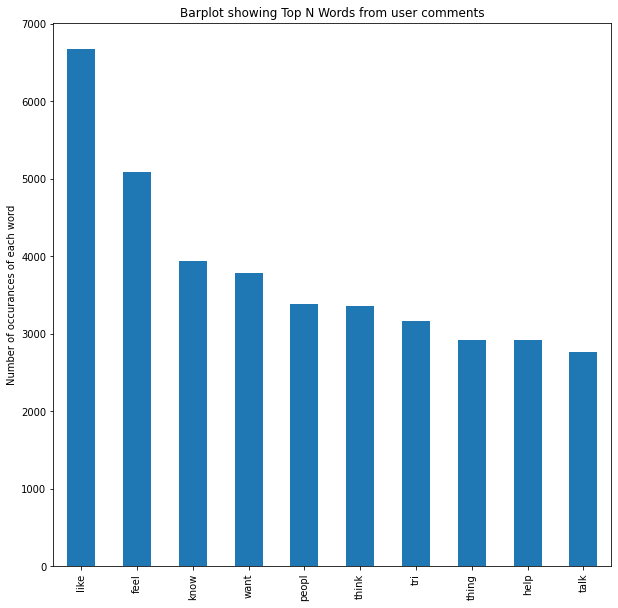

In [ ]:
# using top_words() method, get the top N words and make a bar plot.
hero.top_words(df_grouped['Content']).head(10).plot.bar(figsize=(10,10))
plt.title('Barplot showing Top N Words from user comments')
plt.ylabel('Number of occurances of each word')
plt.show()


In [ ]:
top_words=hero.top_words(df_grouped['Content'])

In [ ]:
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
#add a list of stopwords to the stopwords
stop_w = ["get", "know", "peopl", "think", "go", "thing", "thi", "talk", "time", "friend", "tri", "want", "feel", "make", "like", "one", "realli", "say", "could", "got", "see", "also", "wanna", "look", "mayb", "keep", "still", "way", "aony", "im", "me", "you", "aot", "said", "day", "=", "i", "would", "right", "alway", "happen", ",", ".", "aon", "aom"]
custom_stopwords = default_stopwords.union(set(stop_w))
#Call remove_stopwords and pass the custom_stopwords list
df_grouped['Content'] = hero.remove_stopwords(df_grouped['Content'], custom_stopwords)

Top N words after removing Stopwords

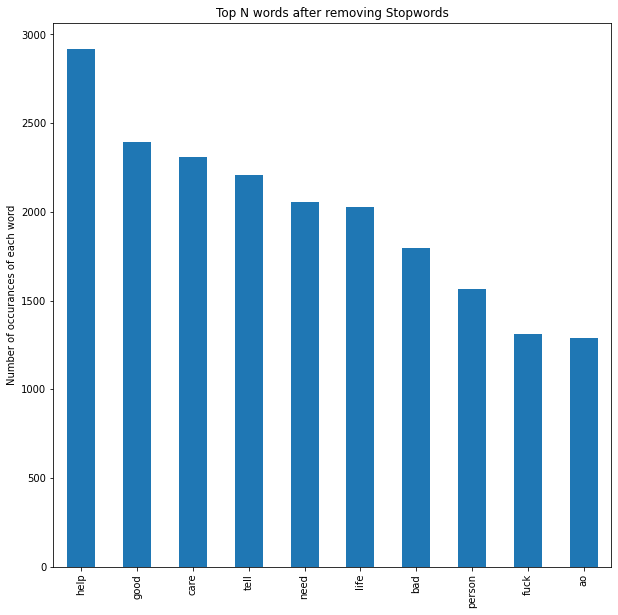

In [ ]:
hero.top_words(df_grouped['Content']).head(10).plot.bar(figsize=(10,10))
plt.title('Top N words after removing Stopwords')
plt.ylabel('Number of occurances of each word')
plt.show()

Word Cloud Visualization

Text(0.5, 1.0, 'Wordcloud showing top N words')

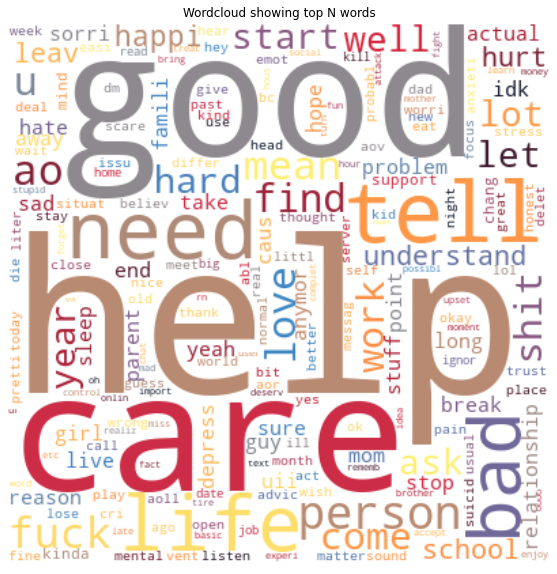

In [ ]:
hero.visualization.wordcloud(df_grouped['Content'],width = 400, height= 400,background_color='White')
plt.title('Wordcloud showing top N words')

Topic Modeling LDA

In [ ]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(df.Content)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=None, min_df=0,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [ ]:
tokenized_reviews = pd.Series(df_grouped.Content).apply(lambda x: x.split())
print(tokenized_reviews[1])

['good', 'u', 'break', 'love', 'makeov', 'hard', 'check', 'discord', 'well', 'care', 'uii', 'betray', 'great', 'stab', 'idk', 'pls', 'help', 'unknown', 'dude', 'answer', 'trip', 'school', 'nurs', 'appoint', 'fall', 'ground', 'u', 'addict', 'person', 'die', 'ur', 'life', 'ur', 'brain', 'u', 'depress', 'dull', 'work', 'cuz', 'teenag', 'natur', 'moodi', 'pressur', 'school', 'famili', 'happi', 'happi', 'long', 'term', 'understand', 'u', 'end', 'care', 'let', 'person', 'ur', 'attent', 'fill', 'ur', 'hobbi', 'relationship', 'ur', 'life', 'balanc', 'possibl', 'mom', 'person', 'date', 'ask', 'end', 'kid', 'mom', 'bad', 'karma', 'mom', 'upset', 'mad', 'cuz', 'famili', 'come', 'cuz', 'relationship', 'end', 'boom', 'vanish', 'guess', 'stay', 'u', 'matter', 'stupid', 'u', 'act', 'ur', 'famili', 'logic', 'harsh', 'u', 'healthi', 'good', 'life', 'decis', 'end', 'u', 'break', 'u', 'love', 'brain', 'chemistri', 'chang', 'affect', 'ur', 'perform']


In [ ]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['hard', 'check', 'discord', 'unknown', 'dude', 'answer', 'trip', 'school', 'nur', 'addict', 'person', 'life', 'brain', 'depress', 'dull', 'work', 'long', 'term', 'end', 'care', 'person', 'fill', 'hobbi', 'relationship', 'person', 'date', 'end', 'mom', 'mad', 'relationship', 'end', 'boom', 'vanish', 'guess', 'matter', 'logic', 'good', 'life', 'break', 'love', 'brain']


In [ ]:
dictionary = corpora.Dictionary(reviews_2)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [ ]:
# Build LDA model
lda_model = LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [ ]:
lda_model.print_topics()

[(0,
  '0.016*"hard" + 0.010*"help" + 0.010*"depress" + 0.008*"good" + 0.008*"year" + 0.008*"month" + 0.008*"end" + 0.007*"bed" + 0.007*"reason" + 0.007*"bad"'),
 (1,
  '0.028*"bad" + 0.018*"help" + 0.017*"good" + 0.015*"person" + 0.013*"care" + 0.011*"lot" + 0.010*"stuff" + 0.010*"sad" + 0.010*"year" + 0.009*"actual"'),
 (2,
  '0.008*"plan" + 0.006*"close" + 0.006*"class" + 0.006*"work" + 0.006*"hair" + 0.005*"server" + 0.004*"ion" + 0.004*"jail" + 0.004*"test" + 0.004*"colleg"'),
 (3,
  '0.014*"attack" + 0.008*"high" + 0.008*"pain" + 0.007*"depress" + 0.007*"mind" + 0.006*"work" + 0.006*"money" + 0.005*"brain" + 0.005*"help" + 0.004*"pill"'),
 (4,
  '0.025*"good" + 0.025*"help" + 0.020*"person" + 0.020*"life" + 0.015*"bad" + 0.011*"love" + 0.010*"work" + 0.010*"care" + 0.008*"relationship" + 0.008*"lot"'),
 (5,
  '0.020*"bad" + 0.017*"good" + 0.014*"shit" + 0.014*"life" + 0.014*"care" + 0.014*"help" + 0.013*"work" + 0.012*"stuff" + 0.012*"mom" + 0.011*"problem"'),
 (6,
  '0.016*"prob

In [ ]:
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

In [ ]:
pd.options.mode.chained_assignment = None 
random_state = 20181126
ldamodel = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=30, random_state=random_state)
topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.067*"the" + 0.037*"of" + 0.030*"," + 0.029*"a" + 0.025*"in" + 0.022*"to"')
(1, '0.072*"I" + 0.060*"." + 0.037*"," + 0.030*"and" + 0.030*"a" + 0.026*"my"')
(2, '0.057*"*" + 0.033*":" + 0.030*"-" + 0.029*"\'" + 0.023*"¬" + 0.020*"|"')
(3, '0.129*"I" + 0.080*"‚" + 0.038*"to" + 0.021*"Äôt" + 0.020*"and" + 0.020*"me"')
(4, '0.055*"and" + 0.048*"her" + 0.045*"she" + 0.033*"he" + 0.032*"me" + 0.029*"was"')
(5, '0.052*"you" + 0.045*"to" + 0.035*"," + 0.034*"it" + 0.032*"and" + 0.022*"the"')
(6, '0.102*"i" + 0.035*"to" + 0.033*"and" + 0.021*"me" + 0.020*"my" + 0.019*"but"')
(7, '0.066*"you" + 0.045*"." + 0.045*"," + 0.042*"to" + 0.020*"that" + 0.017*"?"')
(8, '0.271*"√" + 0.097*"Äö" + 0.089*"¥" + 0.086*"‚" + 0.034*"t" + 0.026*"£"')
(9, '0.118*"Ñ" + 0.033*")" + 0.032*"(" + 0.029*"!" + 0.012*"a" + 0.012*"or"')


In [ ]:
titles = {df_grouped.Content.loc[i] : i for i in df_grouped.index.values}

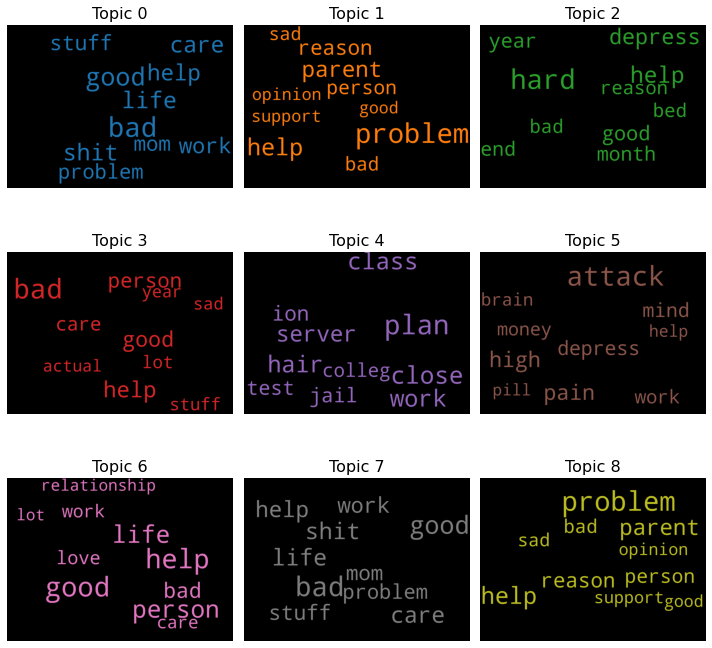

In [ ]:
# 1. Wordcloud of Top N words in each topic
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i-2][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
# Applying Lambda function on comments column to notice positive sentiment among customers. For this, we search for comments like "good, great, like, best, enjoy."
searchfor = ['good', 'great', 'like', 'best', 'enjoy','must', 'love', 'clean']
df_grouped["positive_sentiment"] = df_grouped['Content'].apply(lambda x: 1 if any(i in x for i in searchfor) else 0) 
df_grouped.tail(6)

,Content,positive_sentiment
Author,,
üíúDreamerTheWolfFoxüíö#7237,stuff find manhattan bridg bodi find river ago,0
üíúKamekoüíú#5107,suppos stress stress oao lol matter suicid m...,1
üíû~ùòãùò¶ùò∏ùò∫~üíï#6367,mean let ao interest sexual relat use protect...,0
üñ§Writer_By_Nightüñ§#7103,work long close close start notic justterri...,1
üòàüòàüòà‚ù§#3570,zoink scoob u goodby u love hope u kitter ur ...,1
ü•ÄSomiü•Ä#9186,dr nurs school aod antibiot u neosporin cover,0


Performing Basic Sentiment Analysis:

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity).

The polarity score is a float within the range [-1.0, 1.0].

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [ ]:
df_grouped[['polarity', 'subjectivity']] = df_grouped['Content'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment)) #Checking polarity and subjectivity using sentiment property
df_grouped

,Content,positive_sentiment,polarity,subjectivity
Author,,,,
! Daddy Rey#3248,year old mad joke cheer lmfaoo lmao u bout...,0,-0.084524,0.542857
!Nunu#9000,good u break love makeov hard check discord...,1,0.005357,0.613690
!neo#8684,suicid answer pass problem chanc negat ...,0,0.000000,0.000000
$>sp7r7t<$#0773,blame pain side spectrum bad world person h...,1,-0.035417,0.592361
(T y l e r)#5353,care oooo recent lose famili member tab bit,0,0.000000,0.250000
...,...,...,...,...
üíúKamekoüíú#5107,suppos stress stress oao lol matter suicid m...,1,-0.004346,0.553068
üíû~ùòãùò¶ùò∏ùò∫~üíï#6367,mean let ao interest sexual relat use protect...,0,0.044494,0.630208
üñ§Writer_By_Nightüñ§#7103,work long close close start notic justterri...,1,-0.107572,0.559550


CONCLUSION:

Polarity & Subjectivity Interpretation for top3:

Author - 0.44 defines the polarity of the sentence is slightly positive and subjectivity value 0.53 indicates it is fairly subjective.

Author - 0.50 indicates neutral positivity and subjectivity value 0.675 indicates that the statement is fairly subjective.

Author - 0.0 indicates that the statement shows neutral polarity and very objective.

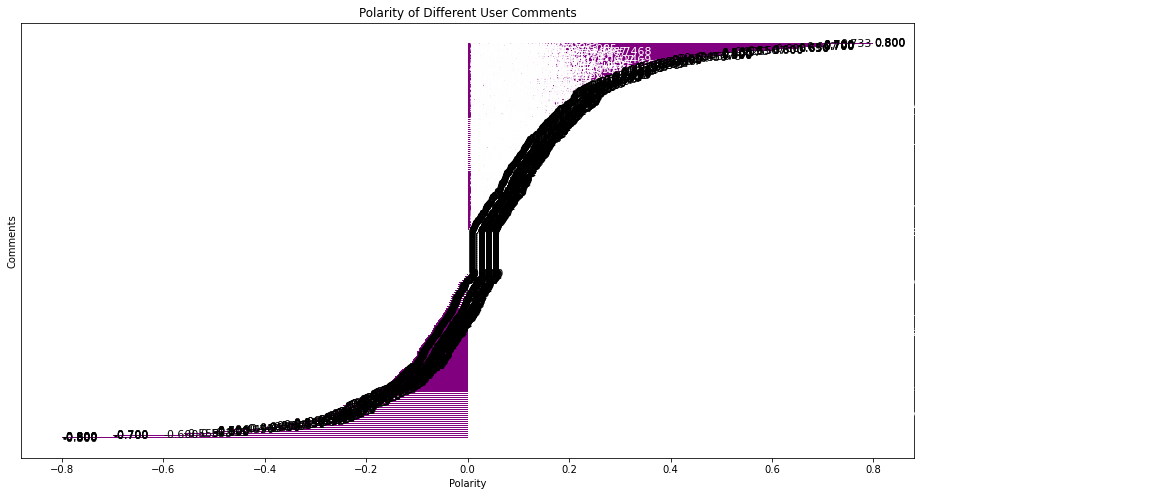

In [ ]:
Author_polarity_sorted=pd.DataFrame(df_grouped.groupby('Author')['polarity'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Comments')
plt.title('Polarity of Different User Comments')
polarity_graph=plt.barh(np.arange(len(Author_polarity_sorted.index)),Author_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,Author in zip(polarity_graph,Author_polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(Author),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,Author_polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

## Build Sub Models for Each Symptom

In [ ]:
# Assign df_train back to df for simplicity
df = df_train

In [ ]:
# Define a function to plot AUC metric
def plot_auc(dep_test, preds):
  fpr, tpr, t = roc_curve(dep_test, preds, pos_label=1)
  auc_score = roc_auc_score(dep_test, preds)

  base = [0 for i in range(len(dep_test))]
  fpr0, tpr0, t0 = roc_curve(dep_test, base, pos_label=1)

  print('AUC:', auc_score)

  plt.plot(fpr, tpr, linestyle='-',color='green', label='Naive Bayes')
  plt.plot(fpr0, tpr0, linestyle='--', color='blue')

  plt.title('ROC')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')

  plt.legend()
  plt.show();

In [ ]:
# Define a function to plot training history for neural network 
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Symptom 1

In [ ]:
# Set indicator for symptoms except symp 1 to 0
df_symp_one_Y = df[df['symp_one']==1][['ID','Content','symp_one']]
df_symp_one_Y=df_symp_one_Y.rename(columns={'symp_one':'symp'})

df_symp_two_Y = df[df['symp_two']== 1][['ID','Content','symp_two']]
df_symp_two_Y=df_symp_two_Y.rename(columns={'symp_two':'symp'})
df_symp_two_Y["symp"].replace({1: 0}, inplace=True)

df_symp_three_Y = df[df['symp_three']==1][['ID','Content','symp_three']]
df_symp_three_Y=df_symp_three_Y.rename(columns={'symp_three':'symp'})
df_symp_three_Y["symp"].replace({1: 0}, inplace=True)

df_symp_four_Y = df[df['symp_four']==1][['ID','Content','symp_four']]
df_symp_four_Y=df_symp_four_Y.rename(columns={'symp_four':'symp'})
df_symp_four_Y["symp"].replace({1: 0}, inplace=True)

df_symp_five_Y = df[df['symp_five']==1][['ID','Content','symp_five']]
df_symp_five_Y=df_symp_five_Y.rename(columns={'symp_five':'symp'})
df_symp_five_Y["symp"].replace({1: 0}, inplace=True)

df_symp_six_Y = df[df['symp_six']==1][['ID','Content','symp_six']]
df_symp_six_Y=df_symp_six_Y.rename(columns={'symp_six':'symp'})
df_symp_six_Y["symp"].replace({1: 0}, inplace=True)

df_symp_seven_Y = df[df['symp_seven']==1][['ID','Content','symp_seven']]
df_symp_seven_Y=df_symp_seven_Y.rename(columns={'symp_seven':'symp'})
df_symp_seven_Y["symp"].replace({1: 0}, inplace=True)

df_symp_None_Y = df[df['None']==1][['ID','Content','None']]
df_symp_None_Y=df_symp_None_Y.rename(columns={'None':'symp'})
df_symp_None_Y["symp"].replace({1: 0}, inplace=True)

In [ ]:
df_trans=pd.concat([df_symp_one_Y,df_symp_two_Y,df_symp_three_Y, df_symp_four_Y, df_symp_five_Y,df_symp_six_Y ,
                   df_symp_seven_Y, df_symp_None_Y], ignore_index=True)

Visualiazation

Text(0.5, 1.0, 'The number of each symptom ')

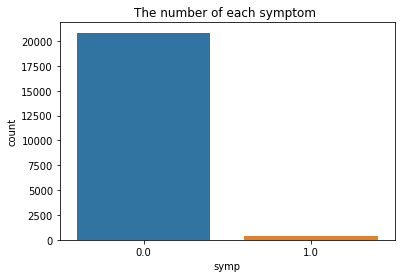

In [ ]:
sns.countplot(x="symp", data=df_trans)
plt.title('The number of each symptom ')

In [ ]:
# add a new column, the length of the content 
df_trans['length']=df_trans['Content'].apply(len)

Text(0.5, 1.0, 'The distribution of text length for symptom 1')

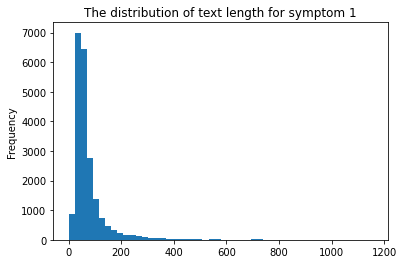

In [ ]:
#distribution of length
df_trans['length'].plot.hist(bins=50)
plt.title('The distribution of text length for symptom 1')

In [ ]:
df_trans['length'].describe()

count    21210.000000
mean        75.945167
std         77.797113
min          0.000000
25%         40.000000
50%         54.000000
75%         81.000000
max       1157.000000
Name: length, dtype: float64

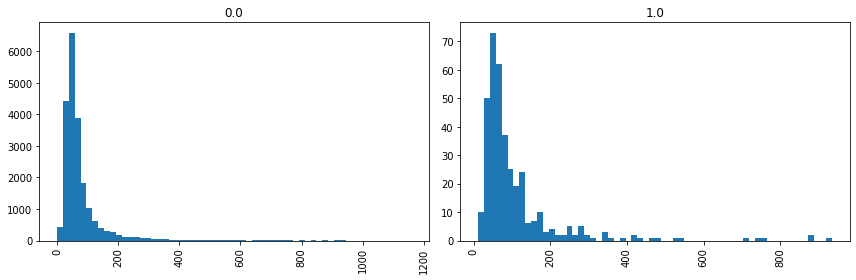

In [ ]:
# The distribution of text length of each symptom
df_trans.hist(column='length',by='symp',bins=60, figsize=(12,4))
plt.tight_layout()


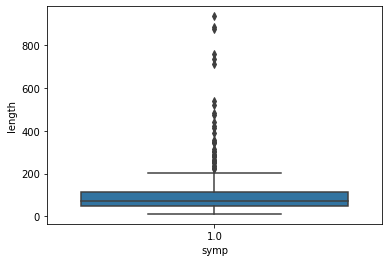

In [ ]:
# symp_one length distribution
sns.boxplot(x='symp',y='length',data=df_trans[df_trans['symp']== 1])

In [ ]:
X=df_trans[['Content']]
y=df_trans['symp'].astype(int)

Over sample to fix imbalance

In [ ]:
# Split train-test data
cont_train, cont_test, dep_train, dep_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# summarize class distribution
print("Before oversampling: ", Counter(dep_train))

# balance data
under = RandomUnderSampler(sampling_strategy=0.4)
over = RandomOverSampler(sampling_strategy="minority")
steps = [('u',under), ('o',over)]
pipeline = Pipeline(steps=steps)
cont_train, dep_train = pipeline.fit_resample(cont_train, dep_train)

# summarize class distribution
print("After oversampling: ", Counter(dep_train))

Before oversampling:  Counter({0: 14602, 1: 245})
After oversampling:  Counter({0: 612, 1: 612})


In [ ]:
# Vectorize text 
vectorizer_sym1 = TfidfVectorizer(analyzer='word',stop_words= 'english')
vectorizer_sym1.fit_transform(cont_train[:,0])
cont_train_vec=vectorizer_sym1.transform(cont_train[:,0]).toarray()
cont_test_vec=vectorizer_sym1.transform(cont_test['Content']).toarray()

### Naive Bayes

In [ ]:
clf = GaussianNB()

clf.fit(cont_train_vec, dep_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[3312 2929]
 [  68   54]]
Recall   : 0.4426229508196721
Accuracy : 0.5289957567185289


AUC: 0.48665356802319937


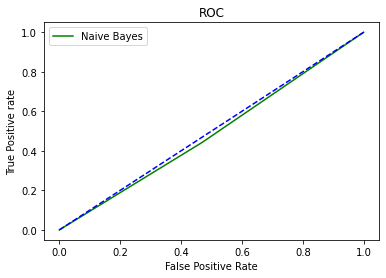

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
NBCLF1 = clf

### Random Forest

In [ ]:
#n_estimators = [300, 800, 1200]
#max_depth = [5, 15, 25, 30]
#min_samples_split = [5, 10, 15, 100]
#min_samples_leaf = [1, 2, 5, 10] 

#params = dict(n_estimators = n_estimators, max_depth = max_depth,  
             # min_samples_split = min_samples_split, 
             # min_samples_leaf = min_samples_leaf)

#clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

clf.fit(cont_train_vec, dep_train)

#print('Best Model:', clf.best_estimator_)
#print('Best score:', clf.best_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5929  312]
 [  53   69]]
Recall   : 0.5655737704918032
Accuracy : 0.9426371208549427


AUC: 0.757790891014208


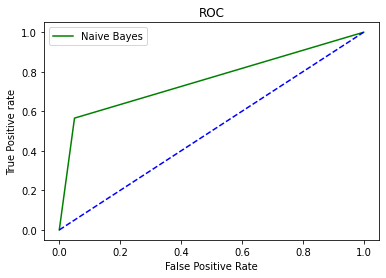

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
RFCLF1 = clf

### SVC

In [ ]:
#Cs = [0.001, 0.01, 0.1, 1, 10]
#gammas = [0.001, 0.01, 0.1, 1]

#params = dict(C = Cs, gamma = gammas)

#clf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

clf.fit(cont_train_vec, dep_train)

#print('Best Model:', clf.best_estimator_)
#print('Best score:', clf.best_score_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#preds = clf.best_estimator_.predict(cont_test_vec)
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5584  657]
 [  51   71]]
Recall   : 0.5819672131147541
Accuracy : 0.8887317303158887


AUC: 0.7383478110117914


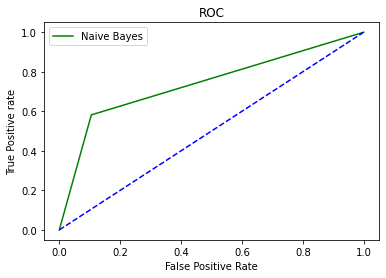

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
SVCCLF1 = clf

### Neural Network Model Keras

In [ ]:
sentences_train = cont_train[:,0]
sentences_test=cont_test['Content'] 
y_train = dep_train
y_test = dep_test

In [ ]:
tokenizer_sym1 = Tokenizer(num_words=5000)
tokenizer_sym1.fit_on_texts(sentences_train)

X_train = tokenizer_sym1.texts_to_sequences(sentences_train)
X_test = tokenizer_sym1.texts_to_sequences(sentences_test)

vocab_size1 = len(tokenizer_sym1.word_index) + 1  

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size1, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           4832      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               400250    
_________________________________________________________________
dense_2 (D

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)


Train on 1224 samples, validate on 6363 samples
Epoch 1/50
1224/1224 [==============================] - 2s 2ms/step - loss: 0.6773 - accuracy: 0.5662 - val_loss: 0.6251 - val_accuracy: 0.7773
Epoch 2/50
1224/1224 [==============================] - 2s 1ms/step - loss: 0.3644 - accuracy: 0.8840 - val_loss: 0.3181 - val_accuracy: 0.9022
Epoch 3/50
1224/1224 [==============================] - 2s 1ms/step - loss: 0.0597 - accuracy: 0.9869 - val_loss: 0.1874 - val_accuracy: 0.9453
Epoch 4/50
1224/1224 [==============================] - 2s 1ms/step - loss: 0.0240 - accuracy: 0.9943 - val_loss: 0.2746 - val_accuracy: 0.9161
Epoch 5/50
1224/1224 [==============================] - 2s 1ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 0.2655 - val_accuracy: 0.9228
Epoch 6/50
1224/1224 [==============================] - 2s 2ms/step - loss: 0.0197 - accuracy: 0.9959 - val_loss: 0.1869 - val_accuracy: 0.9499
Epoch 7/50
1224/1224 [==============================] - 2s 1ms/step - loss: 0.0201 - ac

Training Accuracy: 0.9967
Testing Accuracy:  0.8850


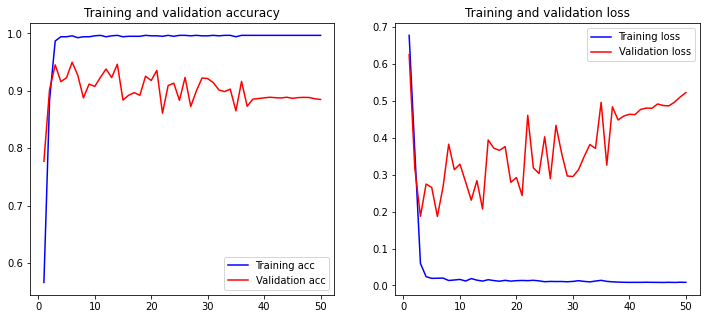

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))


[[5571  670]
 [  62   60]]
Recall   : 0.4918032786885246
Accuracy : 0.884959924563885


AUC: 0.6922243440390228


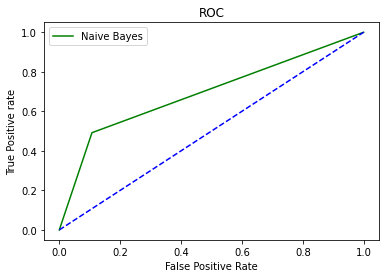

In [ ]:
plot_auc(y_test, y_pred)

In [ ]:
NN1 = model

## Symptom 2

In [ ]:
# Set indicator for symptoms except 2 to 0
df_symp_one_Y = df[df['symp_one']==1][['ID','Content','symp_one']]
df_symp_one_Y=df_symp_one_Y.rename(columns={'symp_one':'symp'})
df_symp_one_Y["symp"].replace({1: 0}, inplace=True)

df_symp_two_Y = df[df['symp_two']== 1][['ID','Content','symp_two']]
df_symp_two_Y=df_symp_two_Y.rename(columns={'symp_two':'symp'})

df_symp_three_Y = df[df['symp_three']==1][['ID','Content','symp_three']]
df_symp_three_Y=df_symp_three_Y.rename(columns={'symp_three':'symp'})
df_symp_three_Y["symp"].replace({1: 0}, inplace=True)

df_symp_four_Y = df[df['symp_four']==1][['ID','Content','symp_four']]
df_symp_four_Y=df_symp_four_Y.rename(columns={'symp_four':'symp'})
df_symp_four_Y["symp"].replace({1: 0}, inplace=True)

df_symp_five_Y = df[df['symp_five']==1][['ID','Content','symp_five']]
df_symp_five_Y=df_symp_five_Y.rename(columns={'symp_five':'symp'})
df_symp_five_Y["symp"].replace({1: 0}, inplace=True)

df_symp_six_Y = df[df['symp_six']==1][['ID','Content','symp_six']]
df_symp_six_Y=df_symp_six_Y.rename(columns={'symp_six':'symp'})
df_symp_six_Y["symp"].replace({1: 0}, inplace=True)

df_symp_seven_Y = df[df['symp_seven']==1][['ID','Content','symp_seven']]
df_symp_seven_Y=df_symp_seven_Y.rename(columns={'symp_seven':'symp'})
df_symp_seven_Y["symp"].replace({1: 0}, inplace=True)

df_symp_None_Y = df[df['None']==1][['ID','Content','None']]
df_symp_None_Y=df_symp_None_Y.rename(columns={'None':'symp'})
df_symp_None_Y["symp"].replace({1: 0}, inplace=True)

In [ ]:
df_trans=pd.concat([df_symp_one_Y,df_symp_two_Y,df_symp_three_Y, df_symp_four_Y, df_symp_five_Y,df_symp_six_Y ,
                   df_symp_seven_Y, df_symp_None_Y], ignore_index=True)

Visualiazation

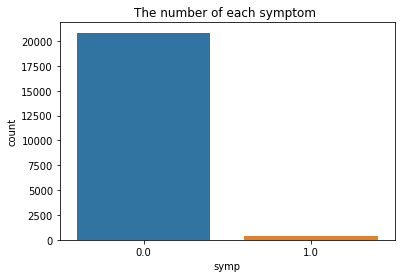

In [ ]:
sns.countplot(x="symp", data=df_trans)
plt.title('The number of each symptom ')

In [ ]:
# add a new column, the length of the content 
df_trans['length']=df_trans['Content'].apply(len)

Text(0.5, 1.0, 'The distribution of text length')

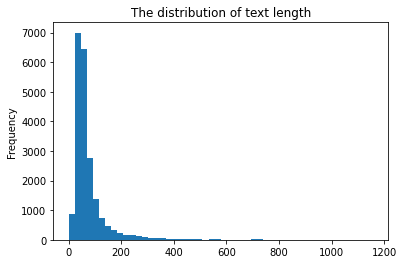

In [ ]:
#distribution of length
df_trans['length'].plot.hist(bins=50)
plt.title('The distribution of text length')

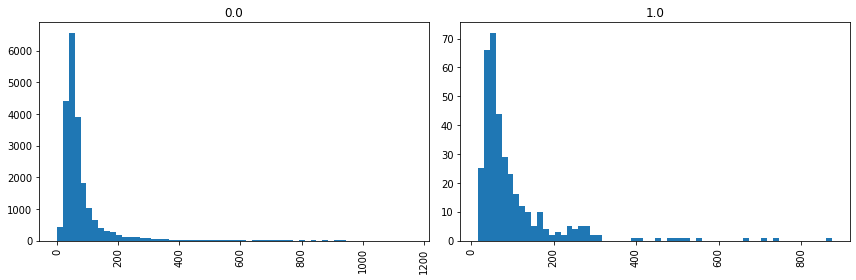

In [ ]:
# The distribution of text length of each symptom
df_trans.hist(column='length',by='symp',bins=60, figsize=(12,4))
plt.tight_layout()


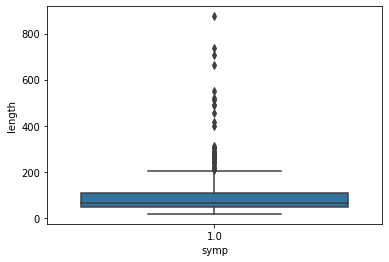

In [ ]:
# symp_one length distribution
sns.boxplot(x='symp',y='length',data=df_trans[df_trans['symp']== 1])

In [ ]:
X=df_trans[['Content']]
y=df_trans['symp'].astype(int)

Resample to fix imbalance

In [ ]:
# Split train-test data
cont_train, cont_test, dep_train, dep_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# summarize class distribution
print("Before oversampling: ", Counter(dep_train))

# balance data
under = RandomUnderSampler(sampling_strategy=0.4)
over = RandomOverSampler(sampling_strategy="minority")
steps = [('u',under), ('o',over)]
pipeline = Pipeline(steps=steps)
cont_train, dep_train = pipeline.fit_resample(cont_train, dep_train)

# summarize class distribution
print("After oversampling: ", Counter(dep_train))

Before oversampling:  Counter({0: 14592, 1: 255})
After oversampling:  Counter({0: 637, 1: 637})


In [ ]:
# Vectorize text 
vectorizer_sym2 = TfidfVectorizer(analyzer='word',stop_words= 'english')
vectorizer_sym2.fit_transform(cont_train[:,0])
cont_train_vec=vectorizer_sym2.transform(cont_train[:,0]).toarray()
cont_test_vec=vectorizer_sym2.transform(cont_test['Content']).toarray()

### Naive Bayes

In [ ]:
clf = GaussianNB()

clf.fit(cont_train_vec, dep_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[3792 2468]
 [  49   54]]
Recall   : 0.5242718446601942
Accuracy : 0.6044318717586045


AUC: 0.5650113216911195


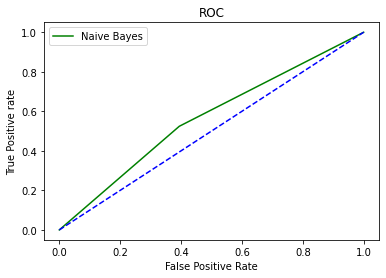

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
NBCLF2 = clf

### Random Forest

In [ ]:
#n_estimators = [300, 800, 1200]
#max_depth = [5, 15, 25, 30]
#min_samples_split = [5, 10, 15, 100]
#min_samples_leaf = [1, 2, 5, 10] 

#params = dict(n_estimators = n_estimators, max_depth = max_depth,  
              #min_samples_split = min_samples_split, 
             #min_samples_leaf = min_samples_leaf)

#clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
clf.fit(cont_train_vec, dep_train)

#print('Best Model:', clf.best_estimator_)
#print('Best score:', clf.best_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5958  302]
 [  25   78]]
Recall   : 0.7572815533980582
Accuracy : 0.9486091466289486


AUC: 0.8545193709482304


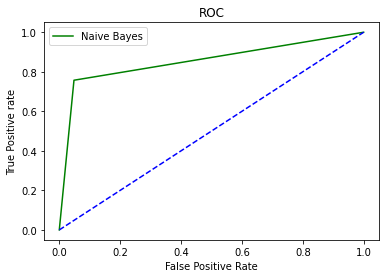

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
RFCLF2 = clf

### SVC

In [ ]:
#Cs = [0.001, 0.01, 0.1, 1, 10]
#gammas = [0.001, 0.01, 0.1, 1]

#params = dict(C = Cs, gamma = gammas)

#clf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
clf.fit(cont_train_vec, dep_train)

#print('Best Model:', clf.best_estimator_)
#print('Best score:', clf.best_score_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[6072  188]
 [  49   54]]
Recall   : 0.5242718446601942
Accuracy : 0.9627534181989628


AUC: 0.7471199478892024


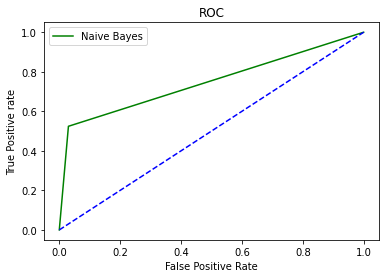

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
SVCCLF2 = clf

### Neural Network Model Keras

In [ ]:
sentences_train = cont_train[:,0]
sentences_test=cont_test['Content'] 
y_train = dep_train
y_test = dep_test

In [ ]:
tokenizer_sym2 = Tokenizer(num_words=5000)
tokenizer_sym2.fit_on_texts(sentences_train)

X_train = tokenizer_sym2.texts_to_sequences(sentences_train)
X_test = tokenizer_sym2.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer_sym2.word_index) + 1  

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           127300    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           4832      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               400250    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
Total params: 532,633
Trainable params: 532,633
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)

Train on 1274 samples, validate on 6363 samples
Epoch 1/50
1274/1274 [==============================] - 2s 2ms/step - loss: 0.6483 - accuracy: 0.6287 - val_loss: 0.3173 - val_accuracy: 0.9709
Epoch 2/50
1274/1274 [==============================] - 2s 2ms/step - loss: 0.2538 - accuracy: 0.9144 - val_loss: 0.2147 - val_accuracy: 0.9406
Epoch 3/50
1274/1274 [==============================] - 2s 1ms/step - loss: 0.0880 - accuracy: 0.9717 - val_loss: 0.1710 - val_accuracy: 0.9543
Epoch 4/50
1274/1274 [==============================] - 2s 1ms/step - loss: 0.0606 - accuracy: 0.9819 - val_loss: 0.1553 - val_accuracy: 0.9577
Epoch 5/50
1274/1274 [==============================] - 2s 1ms/step - loss: 0.0473 - accuracy: 0.9819 - val_loss: 0.3865 - val_accuracy: 0.8757
Epoch 6/50
1274/1274 [==============================] - 2s 1ms/step - loss: 0.0435 - accuracy: 0.9835 - val_loss: 0.3099 - val_accuracy: 0.9063
Epoch 7/50
1274/1274 [==============================] - 2s 1ms/step - loss: 0.0378 - acc

Training Accuracy: 0.9898
Testing Accuracy:  0.8788


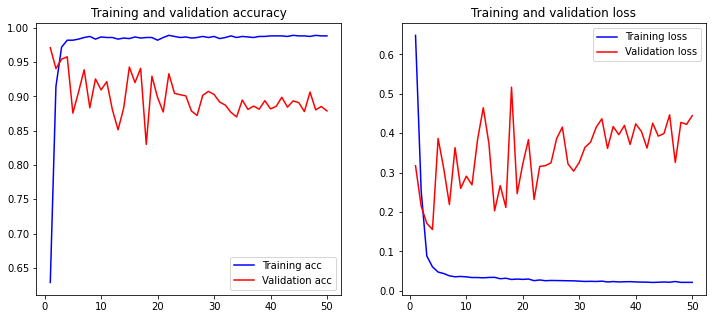

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))

[[5527  733]
 [  38   65]]
Recall   : 0.6310679611650486
Accuracy : 0.8788307402168788


AUC: 0.7569876547039301


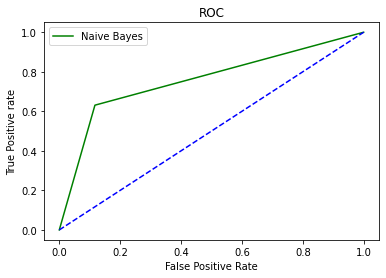

In [ ]:
plot_auc(y_test, y_pred)

In [ ]:
NN2 = model

## Symptom 3

In [ ]:
# Set indicator for symptoms except 3 to 0
df_symp_one_Y = df[df['symp_one']==1][['ID','Content','symp_one']]
df_symp_one_Y=df_symp_one_Y.rename(columns={'symp_one':'symp'})
df_symp_one_Y["symp"].replace({1: 0}, inplace=True)

df_symp_two_Y = df[df['symp_two']== 1][['ID','Content','symp_two']]
df_symp_two_Y=df_symp_two_Y.rename(columns={'symp_two':'symp'})
df_symp_two_Y["symp"].replace({1: 0}, inplace=True)

df_symp_three_Y = df[df['symp_three']==1][['ID','Content','symp_three']]
df_symp_three_Y=df_symp_three_Y.rename(columns={'symp_three':'symp'})

df_symp_four_Y = df[df['symp_four']==1][['ID','Content','symp_four']]
df_symp_four_Y=df_symp_four_Y.rename(columns={'symp_four':'symp'})
df_symp_four_Y["symp"].replace({1: 0}, inplace=True)

df_symp_five_Y = df[df['symp_five']==1][['ID','Content','symp_five']]
df_symp_five_Y=df_symp_five_Y.rename(columns={'symp_five':'symp'})
df_symp_five_Y["symp"].replace({1: 0}, inplace=True)

df_symp_six_Y = df[df['symp_six']==1][['ID','Content','symp_six']]
df_symp_six_Y=df_symp_six_Y.rename(columns={'symp_six':'symp'})
df_symp_six_Y["symp"].replace({1: 0}, inplace=True)

df_symp_seven_Y = df[df['symp_seven']==1][['ID','Content','symp_seven']]
df_symp_seven_Y=df_symp_seven_Y.rename(columns={'symp_seven':'symp'})
df_symp_seven_Y["symp"].replace({1: 0}, inplace=True)

df_symp_None_Y = df[df['None']==1][['ID','Content','None']]
df_symp_None_Y=df_symp_None_Y.rename(columns={'None':'symp'})
df_symp_None_Y["symp"].replace({1: 0}, inplace=True)

In [ ]:
df_trans=pd.concat([df_symp_one_Y,df_symp_two_Y,df_symp_three_Y, df_symp_four_Y, df_symp_five_Y,df_symp_six_Y ,
                   df_symp_seven_Y, df_symp_None_Y], ignore_index=True)

Visualiazation

Text(0.5, 1.0, 'The number of each symptom ')

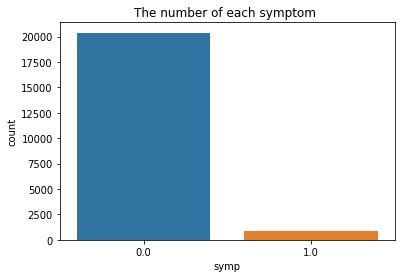

In [ ]:
sns.countplot(x="symp", data=df_trans)
plt.title('The number of each symptom ')

In [ ]:
# add a new column, the length of the content 
df_trans['length']=df_trans['Content'].apply(len)

Text(0.5, 1.0, 'The distribution of text length')

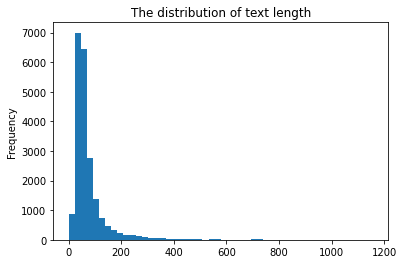

In [ ]:
#distribution of length
df_trans['length'].plot.hist(bins=50)
plt.title('The distribution of text length')

In [ ]:
df_trans['length'].describe()

count    21210.000000
mean        75.945167
std         77.797113
min          0.000000
25%         40.000000
50%         54.000000
75%         81.000000
max       1157.000000
Name: length, dtype: float64

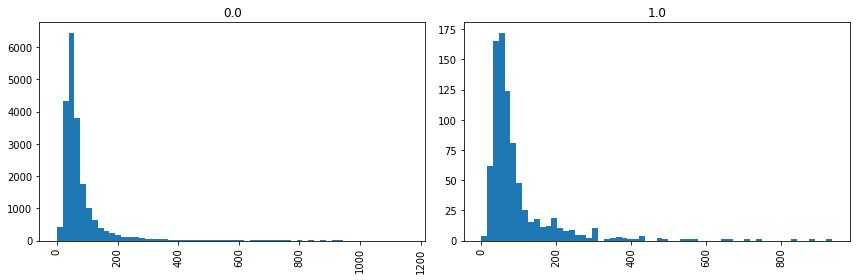

In [ ]:
# The distribution of text length of each symptom
df_trans.hist(column='length',by='symp',bins=60, figsize=(12,4))
plt.tight_layout()


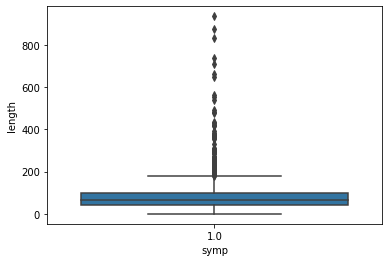

In [ ]:
# symp_one length distribution
sns.boxplot(x='symp',y='length',data=df_trans[df_trans['symp']== 1])

In [ ]:
X=df_trans[['Content']]
y=df_trans['symp'].astype(int)

Over sample to fix imbalance

In [ ]:
# Split train-test data
cont_train, cont_test, dep_train, dep_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# summarize class distribution
print("Before oversampling: ", Counter(dep_train))

# balance data
under = RandomUnderSampler(sampling_strategy=0.4)
over = RandomOverSampler(sampling_strategy="minority")
steps = [('u',under), ('o',over)]
pipeline = Pipeline(steps=steps)
cont_train, dep_train = pipeline.fit_resample(cont_train, dep_train)

# summarize class distribution
print("After oversampling: ", Counter(dep_train))

Before oversampling:  Counter({0: 14265, 1: 582})
After oversampling:  Counter({0: 1455, 1: 1455})


In [ ]:
# Vectorize text 
vectorizer_sym3 = TfidfVectorizer(analyzer='word',stop_words= 'english')
vectorizer_sym3.fit_transform(cont_train[:,0])
cont_train_vec=vectorizer_sym3.transform(cont_train[:,0]).toarray()
cont_test_vec=vectorizer_sym3.transform(cont_test['Content']).toarray()

### Naive Bayes

In [ ]:
clf = GaussianNB()

clf.fit(cont_train_vec, dep_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[2587 3526]
 [  99  151]]
Recall   : 0.604
Accuracy : 0.4303001728744303


AUC: 0.5135982332733519


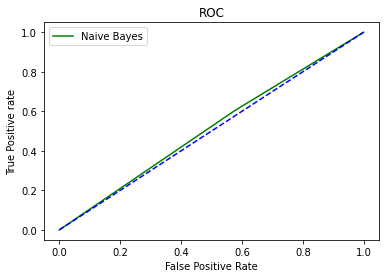

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
NBCLF3 = clf

### Random Forest

In [ ]:
# n_estimators = [300, 800, 1200]
# max_depth = [5, 15, 25, 30]
# min_samples_split = [5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 

# params = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5140  973]
 [ 166   84]]
Recall   : 0.336
Accuracy : 0.820996385352821


AUC: 0.5884155079339114


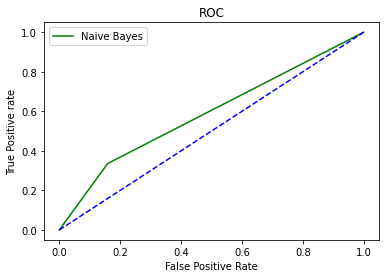

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
RFCLF3 = clf

### SVC

In [ ]:
# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]

# params = dict(C = Cs, gamma = gammas)

# clf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5448  665]
 [ 190   60]]
Recall   : 0.24
Accuracy : 0.8656294200848657


AUC: 0.5656077212497955


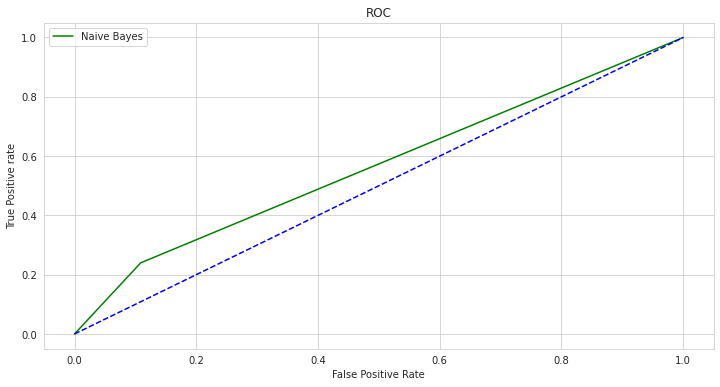

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
SVCCLF3 = clf

### Neural Network Model Keras

In [ ]:
sentences_train = cont_train[:,0]
sentences_test=cont_test['Content'] 
y_train = dep_train
y_test = dep_test

In [ ]:
tokenizer_sym3 = Tokenizer(num_words=5000)
tokenizer_sym3.fit_on_texts(sentences_train)

X_train = tokenizer_sym3.texts_to_sequences(sentences_train)
X_test = tokenizer_sym3.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer_sym3.word_index) + 1  

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           193300    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 32)           4832      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               400250    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 251       
Total params: 598,633
Trainable params: 598,633
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)

Train on 2910 samples, validate on 6363 samples
Epoch 1/50
2910/2910 [==============================] - 3s 1ms/step - loss: 0.6414 - accuracy: 0.6254 - val_loss: 0.4454 - val_accuracy: 0.8417
Epoch 2/50
2910/2910 [==============================] - 3s 970us/step - loss: 0.3024 - accuracy: 0.8852 - val_loss: 0.4976 - val_accuracy: 0.7966
Epoch 3/50
2910/2910 [==============================] - 3s 973us/step - loss: 0.1265 - accuracy: 0.9636 - val_loss: 0.5100 - val_accuracy: 0.8087
Epoch 4/50
2910/2910 [==============================] - 3s 970us/step - loss: 0.0921 - accuracy: 0.9715 - val_loss: 0.4885 - val_accuracy: 0.8296
Epoch 5/50
2910/2910 [==============================] - 3s 969us/step - loss: 0.0787 - accuracy: 0.9732 - val_loss: 0.6715 - val_accuracy: 0.7443
Epoch 6/50
2910/2910 [==============================] - 3s 977us/step - loss: 0.0691 - accuracy: 0.9766 - val_loss: 0.4598 - val_accuracy: 0.8318
Epoch 7/50
2910/2910 [==============================] - 3s 971us/step - loss: 

Training Accuracy: 0.9828
Testing Accuracy:  0.7188


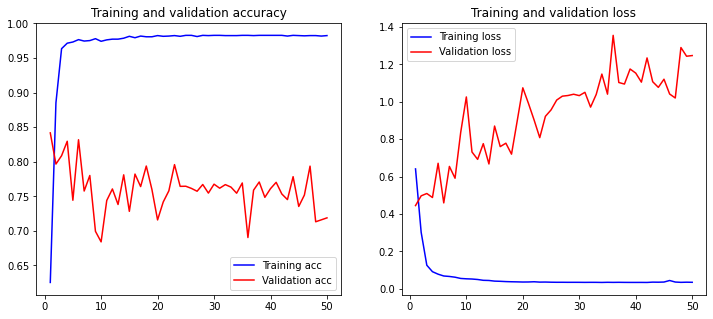

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))


[[4478 1635]
 [ 154   96]]
Recall   : 0.384
Accuracy : 0.7188433129027189


AUC: 0.5582686078848356


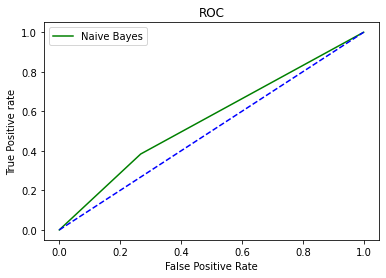

In [ ]:
plot_auc(y_test, y_pred)

In [ ]:
NN3 = model

## Symptom 4

In [ ]:
# Set indicator for symptoms except 4 to 0
df_symp_one_Y = df[df['symp_one']==1][['ID','Content','symp_one']]
df_symp_one_Y=df_symp_one_Y.rename(columns={'symp_one':'symp'})
df_symp_one_Y["symp"].replace({1: 0}, inplace=True)

df_symp_two_Y = df[df['symp_two']== 1][['ID','Content','symp_two']]
df_symp_two_Y=df_symp_two_Y.rename(columns={'symp_two':'symp'})
df_symp_two_Y["symp"].replace({1: 0}, inplace=True)

df_symp_three_Y = df[df['symp_three']==1][['ID','Content','symp_three']]
df_symp_three_Y=df_symp_three_Y.rename(columns={'symp_three':'symp'})
df_symp_three_Y["symp"].replace({1: 0}, inplace=True)

df_symp_four_Y = df[df['symp_four']==1][['ID','Content','symp_four']]
df_symp_four_Y=df_symp_four_Y.rename(columns={'symp_four':'symp'})


df_symp_five_Y = df[df['symp_five']==1][['ID','Content','symp_five']]
df_symp_five_Y=df_symp_five_Y.rename(columns={'symp_five':'symp'})
df_symp_five_Y["symp"].replace({1: 0}, inplace=True)

df_symp_six_Y = df[df['symp_six']==1][['ID','Content','symp_six']]
df_symp_six_Y=df_symp_six_Y.rename(columns={'symp_six':'symp'})
df_symp_six_Y["symp"].replace({1: 0}, inplace=True)

df_symp_seven_Y = df[df['symp_seven']==1][['ID','Content','symp_seven']]
df_symp_seven_Y=df_symp_seven_Y.rename(columns={'symp_seven':'symp'})
df_symp_seven_Y["symp"].replace({1: 0}, inplace=True)

df_symp_None_Y = df[df['None']==1][['ID','Content','None']]
df_symp_None_Y=df_symp_None_Y.rename(columns={'None':'symp'})
df_symp_None_Y["symp"].replace({1: 0}, inplace=True)

In [ ]:
df_trans=pd.concat([df_symp_one_Y,df_symp_two_Y,df_symp_three_Y, df_symp_four_Y, df_symp_five_Y,df_symp_six_Y ,
                   df_symp_seven_Y, df_symp_None_Y], ignore_index=True)

Visualiazation

Text(0.5, 1.0, 'The number of each symptom ')

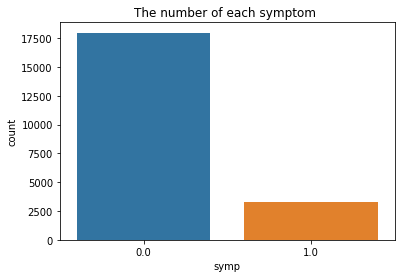

In [ ]:
sns.countplot(x="symp", data=df_trans)
plt.title('The number of each symptom ')

In [ ]:
# add a new column, the length of the content 
df_trans['length']=df_trans['Content'].apply(len)

Text(0.5, 1.0, 'The distribution of text length')

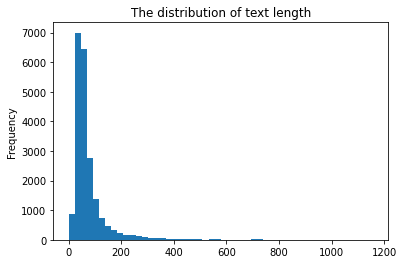

In [ ]:
#distribution of length
df_trans['length'].plot.hist(bins=50)
plt.title('The distribution of text length')

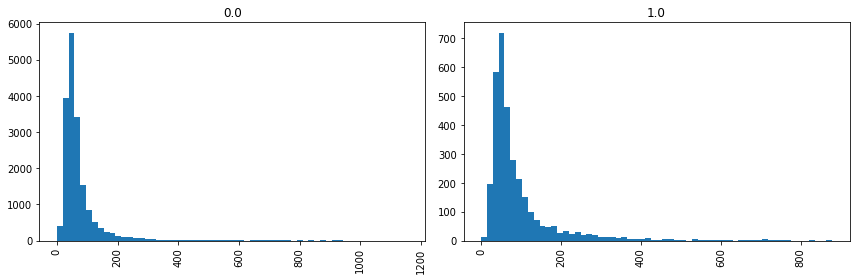

In [ ]:
# The distribution of text length of each symptom
df_trans.hist(column='length',by='symp',bins=60, figsize=(12,4))
plt.tight_layout()


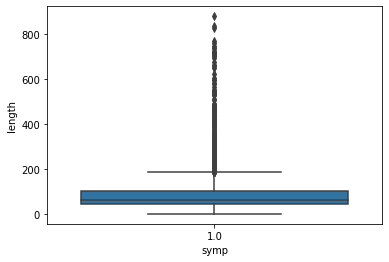

In [ ]:
# symp_one length distribution
sns.boxplot(x='symp',y='length',data=df_trans[df_trans['symp']== 1])

In [ ]:
X=df_trans[['Content']]
y=df_trans['symp'].astype(int)

Over sample to fix imbalance

In [ ]:
# Split train-test data
cont_train, cont_test, dep_train, dep_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# summarize class distribution
print("Before oversampling: ", Counter(dep_train))

# balance data
under = RandomUnderSampler(sampling_strategy=0.4)
over = RandomOverSampler(sampling_strategy="minority")
steps = [('u',under), ('o',over)]
pipeline = Pipeline(steps=steps)
cont_train, dep_train = pipeline.fit_resample(cont_train, dep_train)

# summarize class distribution
print("After oversampling: ", Counter(dep_train))

Before oversampling:  Counter({0: 12573, 1: 2274})
After oversampling:  Counter({0: 5685, 1: 5685})


In [ ]:
# Vectorize text 
vectorizer_sym4 = TfidfVectorizer(analyzer='word',stop_words= 'english')
vectorizer_sym4.fit_transform(cont_train[:,0])
cont_train_vec=vectorizer_sym4.transform(cont_train[:,0]).toarray()
cont_test_vec=vectorizer_sym4.transform(cont_test['Content']).toarray()

### Naive Bayes

In [ ]:
clf = GaussianNB()

clf.fit(cont_train_vec, dep_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[1509 3887]
 [ 302  665]]
Recall   : 0.687693898655636
Accuracy : 0.3416627377023417


AUC: 0.48367274621440065


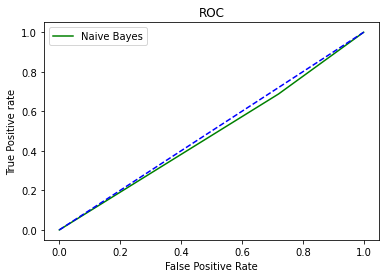

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
NBCLF4 = clf

### Random Forest

In [ ]:
# n_estimators = [300, 800, 1200]
# max_depth = [5, 15, 25, 30, 50]
# min_samples_split = [5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 

# params = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[4262 1134]
 [ 581  386]]
Recall   : 0.39917269906928643
Accuracy : 0.7304730473047305


AUC: 0.5945085141009887


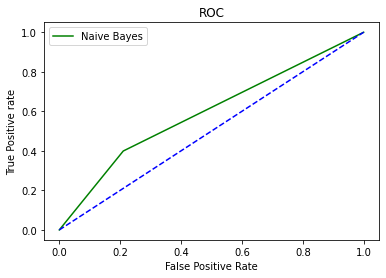

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
RFCLF4 = clf

### SVC

In [ ]:
# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]

# params = dict(C = Cs, gamma = gammas)

# clf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[4556  840]
 [ 740  227]]
Recall   : 0.23474663908996898
Accuracy : 0.7516894546597517


AUC: 0.5395378858904256


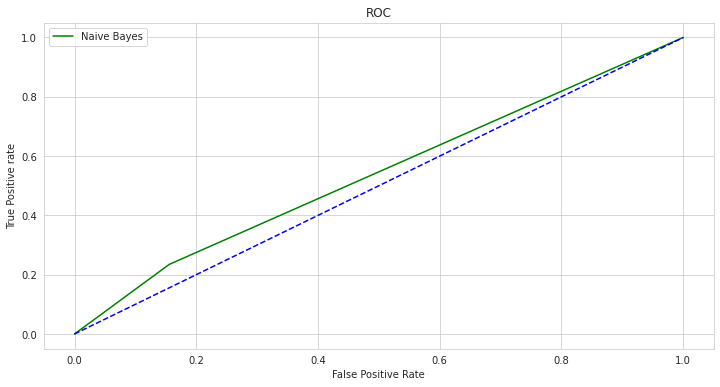

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
SVCCLF4 = clf

### Neural Network Model Keras

In [ ]:
sentences_train = cont_train[:,0]
sentences_test=cont_test['Content'] 
y_train = dep_train
y_test = dep_test

In [ ]:
tokenizer_sym4 = Tokenizer(num_words=5000)
tokenizer_sym4.fit_on_texts(sentences_train)

X_train = tokenizer_sym4.texts_to_sequences(sentences_train)
X_test = tokenizer_sym4.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer_sym4.word_index) + 1  

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           386150    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           4832      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               400250    
_________________________________________________________________
dense_2 (D

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)


Train on 11370 samples, validate on 6363 samples
Epoch 1/50
11370/11370 [==============================] - 10s 867us/step - loss: 0.6071 - accuracy: 0.6675 - val_loss: 0.5657 - val_accuracy: 0.7305
Epoch 2/50
11370/11370 [==============================] - 10s 861us/step - loss: 0.3434 - accuracy: 0.8623 - val_loss: 0.8119 - val_accuracy: 0.6547
Epoch 3/50
11370/11370 [==============================] - 9s 807us/step - loss: 0.2060 - accuracy: 0.9268 - val_loss: 0.7117 - val_accuracy: 0.7058
Epoch 4/50
11370/11370 [==============================] - 9s 819us/step - loss: 0.1555 - accuracy: 0.9447 - val_loss: 0.9765 - val_accuracy: 0.6362
Epoch 5/50
11370/11370 [==============================] - 9s 819us/step - loss: 0.1268 - accuracy: 0.9530 - val_loss: 1.0052 - val_accuracy: 0.6536
Epoch 6/50
11370/11370 [==============================] - 9s 824us/step - loss: 0.1066 - accuracy: 0.9574 - val_loss: 1.0268 - val_accuracy: 0.6997
Epoch 7/50
11370/11370 [==============================] - 10

Training Accuracy: 0.9650
Testing Accuracy:  0.6568


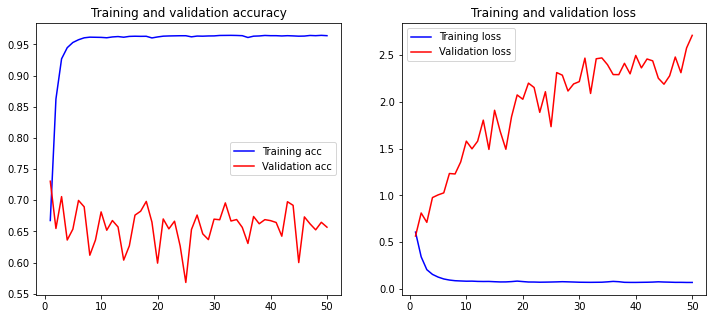

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)
print('Recall   :', metrics.recall_score(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))

[[3878 1518]
 [ 666  301]]
Recall   : 0.3112719751809721
Accuracy : 0.6567656765676567


AUC: 0.514976239629033


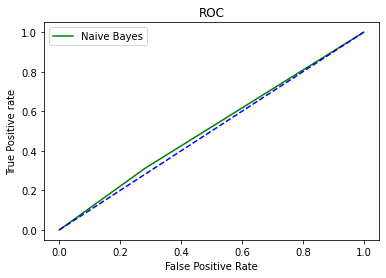

In [ ]:
plot_auc(y_test, y_pred)

In [ ]:
NN4 = model

## Symptom 5

In [ ]:
# Set indicator for symptoms except 5 to 0
df_symp_one_Y = df[df['symp_one']==1][['ID','Content','symp_one']]
df_symp_one_Y=df_symp_one_Y.rename(columns={'symp_one':'symp'})
df_symp_one_Y["symp"].replace({1: 0}, inplace=True)

df_symp_two_Y = df[df['symp_two']== 1][['ID','Content','symp_two']]
df_symp_two_Y=df_symp_two_Y.rename(columns={'symp_two':'symp'})
df_symp_two_Y["symp"].replace({1: 0}, inplace=True)

df_symp_three_Y = df[df['symp_three']==1][['ID','Content','symp_three']]
df_symp_three_Y=df_symp_three_Y.rename(columns={'symp_three':'symp'})
df_symp_three_Y["symp"].replace({1: 0}, inplace=True)

df_symp_four_Y = df[df['symp_four']==1][['ID','Content','symp_four']]
df_symp_four_Y=df_symp_four_Y.rename(columns={'symp_four':'symp'})
df_symp_four_Y["symp"].replace({1: 0}, inplace=True)

df_symp_five_Y = df[df['symp_five']==1][['ID','Content','symp_five']]
df_symp_five_Y=df_symp_five_Y.rename(columns={'symp_five':'symp'})

df_symp_six_Y = df[df['symp_six']==1][['ID','Content','symp_six']]
df_symp_six_Y=df_symp_six_Y.rename(columns={'symp_six':'symp'})
df_symp_six_Y["symp"].replace({1: 0}, inplace=True)

df_symp_seven_Y = df[df['symp_seven']==1][['ID','Content','symp_seven']]
df_symp_seven_Y=df_symp_seven_Y.rename(columns={'symp_seven':'symp'})
df_symp_seven_Y["symp"].replace({1: 0}, inplace=True)

df_symp_None_Y = df[df['None']==1][['ID','Content','None']]
df_symp_None_Y=df_symp_None_Y.rename(columns={'None':'symp'})
df_symp_None_Y["symp"].replace({1: 0}, inplace=True)

In [ ]:
df_trans=pd.concat([df_symp_one_Y,df_symp_two_Y,df_symp_three_Y, df_symp_four_Y, df_symp_five_Y,df_symp_six_Y ,
                   df_symp_seven_Y, df_symp_None_Y], ignore_index=True)

Visualiazation

Text(0.5, 1.0, 'The number of each symptom ')

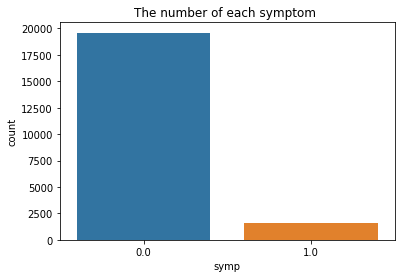

In [ ]:
sns.countplot(x="symp", data=df_trans)
plt.title('The number of each symptom ')

In [ ]:
# add a new column, the length of the content 
df_trans['length']=df_trans['Content'].apply(len)

Text(0.5, 1.0, 'The distribution of text length')

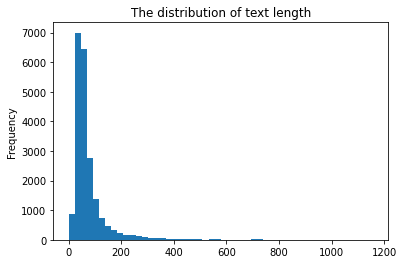

In [ ]:
#distribution of length
df_trans['length'].plot.hist(bins=50)
plt.title('The distribution of text length')

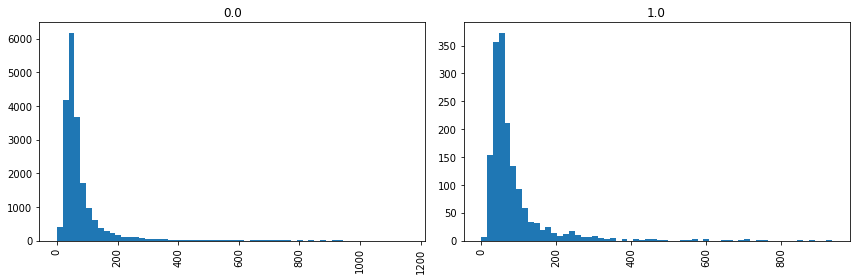

In [ ]:
# The distribution of text length of each symptom
df_trans.hist(column='length',by='symp',bins=60, figsize=(12,4))
plt.tight_layout()


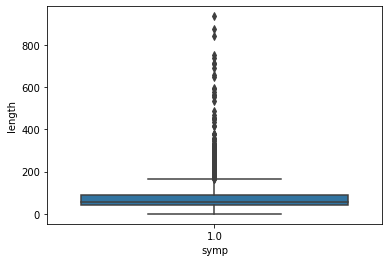

In [ ]:
# symp_one length distribution
sns.boxplot(x='symp',y='length',data=df_trans[df_trans['symp']== 1])

In [ ]:
X=df_trans[['Content']]
y=df_trans['symp'].astype(int)

Over sample to fix imbalance

In [ ]:
# Split train-test data
cont_train, cont_test, dep_train, dep_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# summarize class distribution
print("Before oversampling: ", Counter(dep_train))

# balance data
under = RandomUnderSampler(sampling_strategy=0.4)
over = RandomOverSampler(sampling_strategy="minority")
steps = [('u',under), ('o',over)]
pipeline = Pipeline(steps=steps)
cont_train, dep_train = pipeline.fit_resample(cont_train, dep_train)

# summarize class distribution
print("After oversampling: ", Counter(dep_train))

Before oversampling:  Counter({0: 13725, 1: 1122})
After oversampling:  Counter({0: 2805, 1: 2805})


In [ ]:
# Vectorize text 
vectorizer_sym5 = TfidfVectorizer(analyzer='word',stop_words= 'english')
vectorizer_sym5.fit_transform(cont_train[:,0])
cont_train_vec=vectorizer_sym5.transform(cont_train[:,0]).toarray()
cont_test_vec=vectorizer_sym5.transform(cont_test['Content']).toarray()

### Naive Bayes

In [ ]:
clf = GaussianNB()

clf.fit(cont_train_vec, dep_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[2065 3808]
 [ 162  328]]
Recall   : 0.6693877551020408
Accuracy : 0.3760804651893761


AUC: 0.5104984067524506


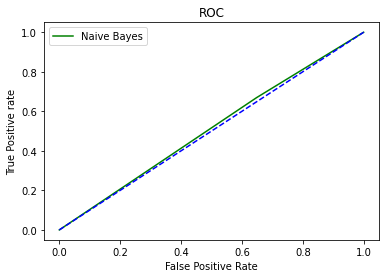

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
NBCLF5 = clf

### Random Forest

In [ ]:
# n_estimators = [300, 800, 1200]
# max_depth = [5, 15, 25, 30]
# min_samples_split = [5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 

# params = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[4824 1049]
 [ 325  165]]
Recall   : 0.336734693877551
Accuracy : 0.7840641206977841


AUC: 0.5790603488117535


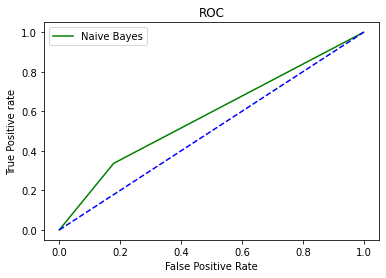

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
RFCLF5 = clf

### SVC

In [ ]:
# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]

# params = dict(C = Cs, gamma = gammas)

# clf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False) 

clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5158  715]
 [ 384  106]]
Recall   : 0.2163265306122449
Accuracy : 0.8272827282728272


AUC: 0.5472914791661599


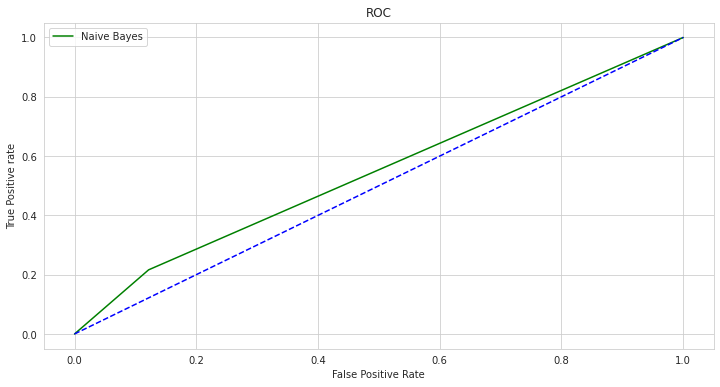

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
SVCCLF5 = clf

### Neural Network Model Keras

In [ ]:
sentences_train = cont_train[:,0]
sentences_test=cont_test['Content'] 
y_train = dep_train
y_test = dep_test

In [ ]:
tokenizer_sym5 = Tokenizer(num_words=5000)
tokenizer_sym5.fit_on_texts(sentences_train)

X_train = tokenizer_sym5.texts_to_sequences(sentences_train)
X_test = tokenizer_sym5.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer_sym5.word_index) + 1  

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           268250    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           4832      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               400250    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
Total params: 673,583
Trainable params: 673,583
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)

Train on 5610 samples, validate on 6363 samples
Epoch 1/50
5610/5610 [==============================] - 5s 953us/step - loss: 0.6384 - accuracy: 0.6328 - val_loss: 0.5175 - val_accuracy: 0.7801
Epoch 2/50
5610/5610 [==============================] - 5s 900us/step - loss: 0.3159 - accuracy: 0.8791 - val_loss: 0.5597 - val_accuracy: 0.7688
Epoch 3/50
5610/5610 [==============================] - 5s 949us/step - loss: 0.1647 - accuracy: 0.9485 - val_loss: 0.6174 - val_accuracy: 0.7547
Epoch 4/50
5610/5610 [==============================] - 5s 901us/step - loss: 0.1191 - accuracy: 0.9627 - val_loss: 0.6984 - val_accuracy: 0.7393
Epoch 5/50
5610/5610 [==============================] - 5s 906us/step - loss: 0.1008 - accuracy: 0.9658 - val_loss: 0.7097 - val_accuracy: 0.7011
Epoch 6/50
5610/5610 [==============================] - 5s 915us/step - loss: 0.0886 - accuracy: 0.9692 - val_loss: 0.7836 - val_accuracy: 0.7192
Epoch 7/50
5610/5610 [==============================] - 5s 903us/step - loss

Training Accuracy: 0.9747
Testing Accuracy:  0.7058


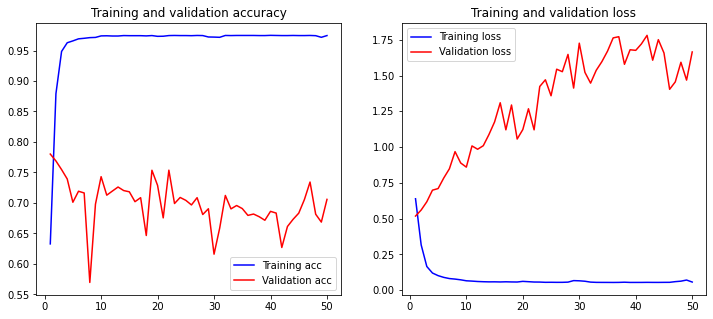

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)
print('Recall   :', metrics.recall_score(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))

[[4326 1547]
 [ 325  165]]
Recall   : 0.336734693877551
Accuracy : 0.7057991513437057


AUC: 0.5366629369268565


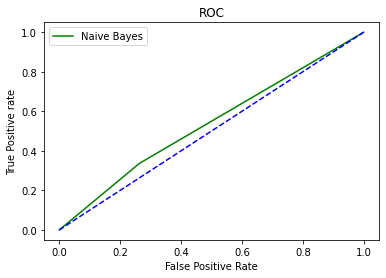

In [ ]:
plot_auc(y_test, y_pred)

In [ ]:
NN5 = model

## Symptom 6

In [ ]:
# Set indicator for symptoms except 6 to 0
df_symp_one_Y = df[df['symp_one']==1][['ID','Content','symp_one']]
df_symp_one_Y=df_symp_one_Y.rename(columns={'symp_one':'symp'})
df_symp_one_Y["symp"].replace({1: 0}, inplace=True)

df_symp_two_Y = df[df['symp_two']== 1][['ID','Content','symp_two']]
df_symp_two_Y=df_symp_two_Y.rename(columns={'symp_two':'symp'})
df_symp_two_Y["symp"].replace({1: 0}, inplace=True)

df_symp_three_Y = df[df['symp_three']==1][['ID','Content','symp_three']]
df_symp_three_Y=df_symp_three_Y.rename(columns={'symp_three':'symp'})
df_symp_three_Y["symp"].replace({1: 0}, inplace=True)

df_symp_four_Y = df[df['symp_four']==1][['ID','Content','symp_four']]
df_symp_four_Y=df_symp_four_Y.rename(columns={'symp_four':'symp'})
df_symp_four_Y["symp"].replace({1: 0}, inplace=True)

df_symp_five_Y = df[df['symp_five']==1][['ID','Content','symp_five']]
df_symp_five_Y=df_symp_five_Y.rename(columns={'symp_five':'symp'})
df_symp_five_Y["symp"].replace({1: 0}, inplace=True)

df_symp_six_Y = df[df['symp_six']==1][['ID','Content','symp_six']]
df_symp_six_Y=df_symp_six_Y.rename(columns={'symp_six':'symp'})

df_symp_seven_Y = df[df['symp_seven']==1][['ID','Content','symp_seven']]
df_symp_seven_Y=df_symp_seven_Y.rename(columns={'symp_seven':'symp'})
df_symp_seven_Y["symp"].replace({1: 0}, inplace=True)

df_symp_None_Y = df[df['None']==1][['ID','Content','None']]
df_symp_None_Y=df_symp_None_Y.rename(columns={'None':'symp'})
df_symp_None_Y["symp"].replace({1: 0}, inplace=True)

In [ ]:
df_trans=pd.concat([df_symp_one_Y,df_symp_two_Y,df_symp_three_Y, df_symp_four_Y, df_symp_five_Y,df_symp_six_Y ,
                   df_symp_seven_Y, df_symp_None_Y], ignore_index=True)

Visualiazation

Text(0.5, 1.0, 'The number of each symptom ')

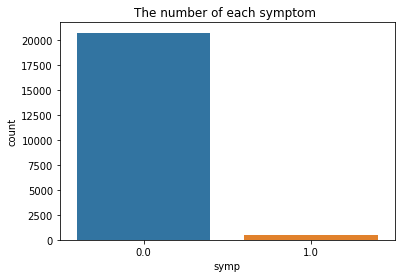

In [ ]:
sns.countplot(x="symp", data=df_trans)
plt.title('The number of each symptom ')

In [ ]:
# add a new column, the length of the content 
df_trans['length']=df_trans['Content'].apply(len)

Text(0.5, 1.0, 'The distribution of text length')

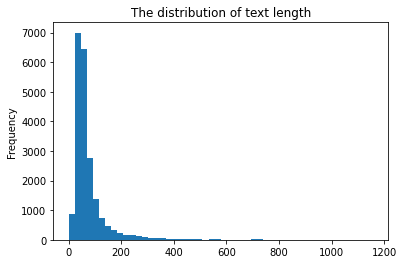

In [ ]:
#distribution of length
df_trans['length'].plot.hist(bins=50)
plt.title('The distribution of text length')

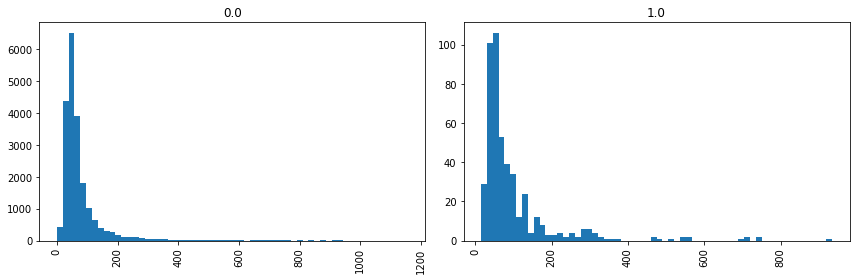

In [ ]:
# The distribution of text length of each symptom
df_trans.hist(column='length',by='symp',bins=60, figsize=(12,4))
plt.tight_layout()


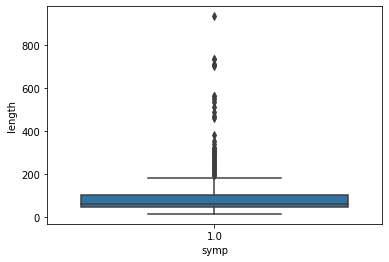

In [ ]:
# symp_one length distribution
sns.boxplot(x='symp',y='length',data=df_trans[df_trans['symp']== 1])

In [ ]:
X=df_trans[['Content']]
y=df_trans['symp'].astype(int)

Over sample to fix imbalance

In [ ]:
# Split train-test data
cont_train, cont_test, dep_train, dep_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# summarize class distribution
print("Before oversampling: ", Counter(dep_train))

# balance data
under = RandomUnderSampler(sampling_strategy=0.4)
over = RandomOverSampler(sampling_strategy="minority")
steps = [('u',under), ('o',over)]
pipeline = Pipeline(steps=steps)
cont_train, dep_train = pipeline.fit_resample(cont_train, dep_train)

# summarize class distribution
print("After oversampling: ", Counter(dep_train))

Before oversampling:  Counter({0: 14524, 1: 323})
After oversampling:  Counter({0: 807, 1: 807})


In [ ]:
# Vectorize text 
vectorizer_sym6 = TfidfVectorizer(analyzer='word',stop_words= 'english')
vectorizer_sym6.fit_transform(cont_train[:,0])
cont_train_vec=vectorizer_sym6.transform(cont_train[:,0]).toarray()
cont_test_vec=vectorizer_sym6.transform(cont_test['Content']).toarray()

### Naive Bayes

In [ ]:
clf = GaussianNB()

clf.fit(cont_train_vec, dep_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[2996 3215]
 [  74   78]]
Recall   : 0.5131578947368421
Accuracy : 0.4831054534024831


AUC: 0.4977639417332576


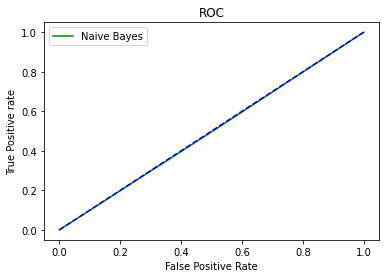

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
NBCLF6 = clf

### Random Forest

In [ ]:
# n_estimators = [300, 800, 1200]
# max_depth = [5, 15, 25, 30]
# min_samples_split = [5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 

# params = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5483  728]
 [ 106   46]]
Recall   : 0.3026315789473684
Accuracy : 0.8689297501178689


AUC: 0.5927100899083968


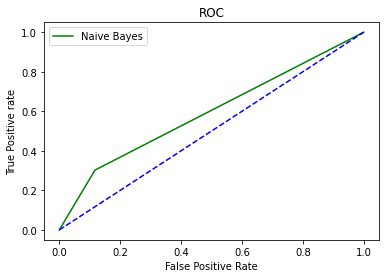

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
RFCLF6 = clf

### SVC

In [ ]:
# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]

# params = dict(C = Cs, gamma = gammas)

# clf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5803  408]
 [ 114   38]]
Recall   : 0.25
Accuracy : 0.917963224893918


AUC: 0.5921550474963774


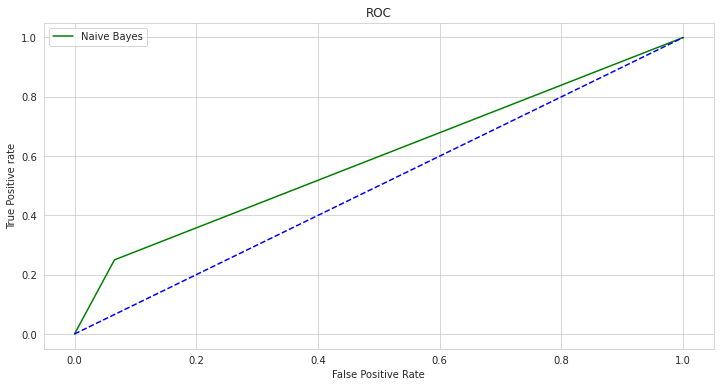

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
SVCCLF6 = clf

### Neural Network Model Keras

In [ ]:
sentences_train = cont_train[:,0]
sentences_test=cont_test['Content'] 
y_train = dep_train
y_test = dep_test

In [ ]:
tokenizer_sym6 = Tokenizer(num_words=5000)
tokenizer_sym6.fit_on_texts(sentences_train)

X_train = tokenizer_sym6.texts_to_sequences(sentences_train)
X_test = tokenizer_sym6.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer_sym6.word_index) + 1  

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           144800    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 32)           4832      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               400250    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 251       
Total params: 550,133
Trainable params: 550,133
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)

Train on 1614 samples, validate on 6363 samples
Epoch 1/50
1614/1614 [==============================] - 2s 1ms/step - loss: 0.6805 - accuracy: 0.5892 - val_loss: 0.6551 - val_accuracy: 0.8529
Epoch 2/50
1614/1614 [==============================] - 1s 909us/step - loss: 0.3693 - accuracy: 0.8866 - val_loss: 0.2398 - val_accuracy: 0.9375
Epoch 3/50
1614/1614 [==============================] - 1s 903us/step - loss: 0.0692 - accuracy: 0.9833 - val_loss: 0.7632 - val_accuracy: 0.6874
Epoch 4/50
1614/1614 [==============================] - 1s 885us/step - loss: 0.0414 - accuracy: 0.9926 - val_loss: 0.2689 - val_accuracy: 0.9225
Epoch 5/50
1614/1614 [==============================] - 1s 897us/step - loss: 0.0403 - accuracy: 0.9913 - val_loss: 0.4190 - val_accuracy: 0.8612
Epoch 6/50
1614/1614 [==============================] - 1s 907us/step - loss: 0.0269 - accuracy: 0.9938 - val_loss: 0.4771 - val_accuracy: 0.8333
Epoch 7/50
1614/1614 [==============================] - 1s 883us/step - loss: 

Training Accuracy: 0.9957
Testing Accuracy:  0.8307


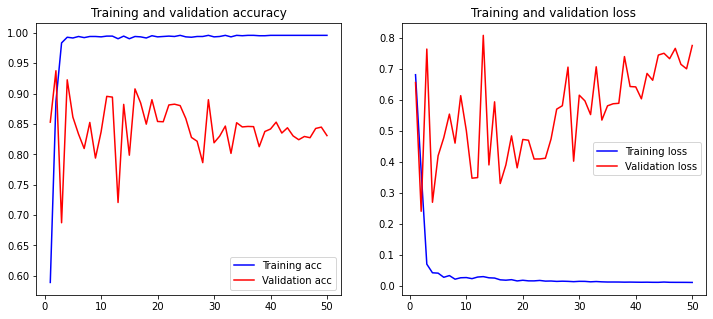

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)
print('Recall   :', metrics.recall_score(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))


[[5247  964]
 [ 113   39]]
Recall   : 0.2565789473684211
Accuracy : 0.8307402168788307


AUC: 0.5506852231609454


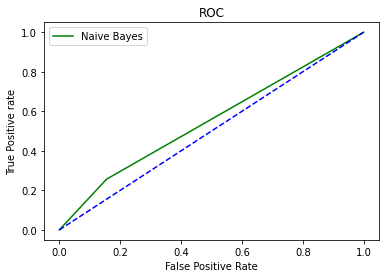

In [ ]:
plot_auc(y_test, y_pred)

In [ ]:
NN6 = model

## Symptom 7

In [ ]:
# Set indicator for symptoms except 7 to 0
df_symp_one_Y = df[df['symp_one']==1][['ID','Content','symp_one']]
df_symp_one_Y=df_symp_one_Y.rename(columns={'symp_one':'symp'})
df_symp_one_Y["symp"].replace({1: 0}, inplace=True)

df_symp_two_Y = df[df['symp_two']== 1][['ID','Content','symp_two']]
df_symp_two_Y=df_symp_two_Y.rename(columns={'symp_two':'symp'})
df_symp_two_Y["symp"].replace({1: 0}, inplace=True)

df_symp_three_Y = df[df['symp_three']==1][['ID','Content','symp_three']]
df_symp_three_Y=df_symp_three_Y.rename(columns={'symp_three':'symp'})
df_symp_three_Y["symp"].replace({1: 0}, inplace=True)

df_symp_four_Y = df[df['symp_four']==1][['ID','Content','symp_four']]
df_symp_four_Y=df_symp_four_Y.rename(columns={'symp_four':'symp'})
df_symp_four_Y["symp"].replace({1: 0}, inplace=True)

df_symp_five_Y = df[df['symp_five']==1][['ID','Content','symp_five']]
df_symp_five_Y=df_symp_five_Y.rename(columns={'symp_five':'symp'})
df_symp_five_Y["symp"].replace({1: 0}, inplace=True)

df_symp_six_Y = df[df['symp_six']==1][['ID','Content','symp_six']]
df_symp_six_Y=df_symp_six_Y.rename(columns={'symp_six':'symp'})
df_symp_six_Y["symp"].replace({1: 0}, inplace=True)

df_symp_seven_Y = df[df['symp_seven']==1][['ID','Content','symp_seven']]
df_symp_seven_Y=df_symp_seven_Y.rename(columns={'symp_seven':'symp'})

df_symp_None_Y = df[df['None']==1][['ID','Content','None']]
df_symp_None_Y=df_symp_None_Y.rename(columns={'None':'symp'})
df_symp_None_Y["symp"].replace({1: 0}, inplace=True)

In [ ]:
df_trans=pd.concat([df_symp_one_Y,df_symp_two_Y,df_symp_three_Y, df_symp_four_Y, df_symp_five_Y,df_symp_six_Y ,
                   df_symp_seven_Y, df_symp_None_Y], ignore_index=True)

Visualiazation

Text(0.5, 1.0, 'The number of each symptom ')

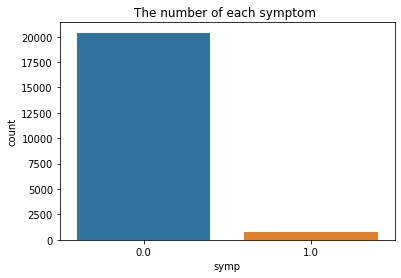

In [ ]:
sns.countplot(x="symp", data=df_trans)
plt.title('The number of each symptom ')

In [ ]:
# add a new column, the length of the content 
df_trans['length']=df_trans['Content'].apply(len)

Text(0.5, 1.0, 'The distribution of text length')

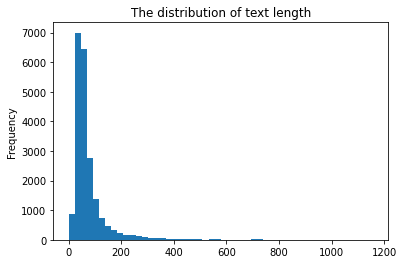

In [ ]:
#distribution of length
df_trans['length'].plot.hist(bins=50)
plt.title('The distribution of text length')

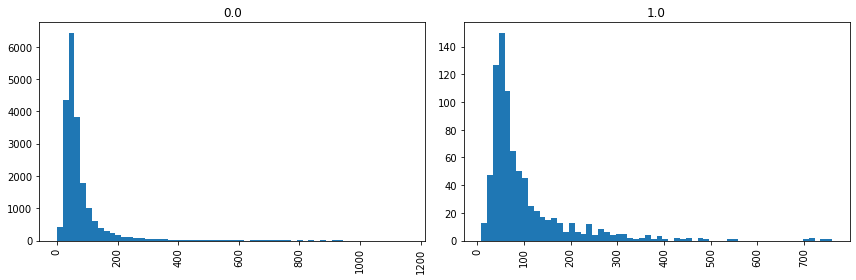

In [ ]:
# The distribution of text length of each symptom
df_trans.hist(column='length',by='symp',bins=60, figsize=(12,4))
plt.tight_layout()


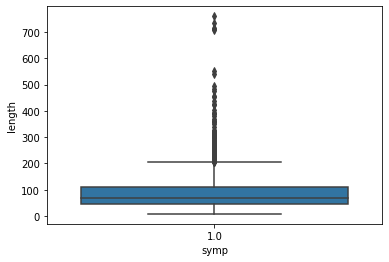

In [ ]:
# symp_one length distribution
sns.boxplot(x='symp',y='length',data=df_trans[df_trans['symp']== 1])

In [ ]:
X=df_trans[['Content']]
y=df_trans['symp'].astype(int)

Resample to fix imbalance

In [ ]:
# Split train-test data
cont_train, cont_test, dep_train, dep_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# summarize class distribution
print("Before oversampling: ", Counter(dep_train))

# balance data
under = RandomUnderSampler(sampling_strategy=0.4)
over = RandomOverSampler(sampling_strategy="minority")
steps = [('u',under), ('o',over)]
pipeline = Pipeline(steps=steps)
cont_train, dep_train = pipeline.fit_resample(cont_train, dep_train)

# summarize class distribution
print("After oversampling: ", Counter(dep_train))

Before oversampling:  Counter({0: 14293, 1: 554})
After oversampling:  Counter({0: 1385, 1: 1385})


In [ ]:
# Vectorize text 
vectorizer_sym7 = TfidfVectorizer(analyzer='word',stop_words= 'english')
vectorizer_sym7.fit_transform(cont_train[:,0])
cont_train_vec=vectorizer_sym7.transform(cont_train[:,0]).toarray()
cont_test_vec=vectorizer_sym7.transform(cont_test['Content']).toarray()

### Naive Bayes

In [ ]:
clf = GaussianNB()

clf.fit(cont_train_vec, dep_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[2692 3410]
 [ 109  152]]
Recall   : 0.5823754789272031
Accuracy : 0.44695898161244696


AUC: 0.5117711547372823


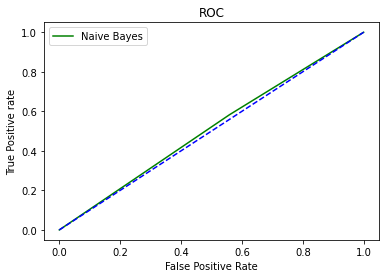

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
NBCLF7 = clf

### Random Forest

In [ ]:
# n_estimators = [300, 800, 1200]
# max_depth = [5, 15, 25, 30]
# min_samples_split = [5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 

# params = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5620  482]
 [ 119  142]]
Recall   : 0.5440613026819924
Accuracy : 0.9055476976269056


AUC: 0.732535403881147


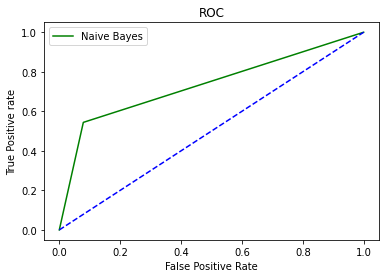

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
RFCLF7 = clf

### SVC

In [ ]:
# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]

# params = dict(C = Cs, gamma = gammas)

# clf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=3, cv=3, verbose=1, scoring='recall')

clf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

clf.fit(cont_train_vec, dep_train)

# print('Best Model:', clf.best_estimator_)
# print('Best score:', clf.best_score_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
preds = clf.predict(cont_test_vec)

In [ ]:
confusionMatrix = confusion_matrix(dep_test, preds)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(dep_test, preds))
print('Accuracy :', metrics.accuracy_score(dep_test, preds))


[[5650  452]
 [ 143  118]]
Recall   : 0.4521072796934866
Accuracy : 0.9064906490649065


AUC: 0.6890166028097062


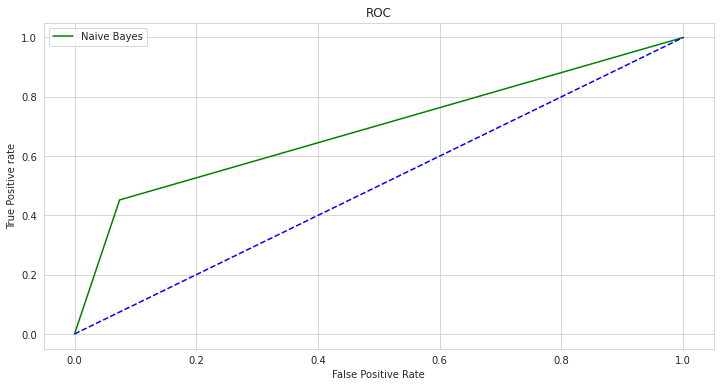

In [ ]:
plot_auc(dep_test, preds)

In [ ]:
SVCCLF7 = clf

### Neural Network Model Keras

In [ ]:
sentences_train = cont_train[:,0]
sentences_test=cont_test['Content'] 
y_train = dep_train
y_test = dep_test

In [ ]:
tokenizer_sym7 = Tokenizer(num_words=5000)
tokenizer_sym7.fit_on_texts(sentences_train)

X_train = tokenizer_sym7.texts_to_sequences(sentences_train)
X_test = tokenizer_sym7.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer_sym7.word_index) + 1  

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           190200    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 32)           4832      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               400250    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 251       
Total params: 595,533
Trainable params: 595,533
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)

Train on 2770 samples, validate on 6363 samples
Epoch 1/50
2770/2770 [==============================] - 2s 870us/step - loss: 0.5938 - accuracy: 0.6704 - val_loss: 0.2981 - val_accuracy: 0.9148
Epoch 2/50
2770/2770 [==============================] - 2s 780us/step - loss: 0.2362 - accuracy: 0.9137 - val_loss: 0.3952 - val_accuracy: 0.8664
Epoch 3/50
2770/2770 [==============================] - 2s 781us/step - loss: 0.1060 - accuracy: 0.9682 - val_loss: 0.4539 - val_accuracy: 0.8474
Epoch 4/50
2770/2770 [==============================] - 2s 759us/step - loss: 0.0707 - accuracy: 0.9780 - val_loss: 0.4894 - val_accuracy: 0.8318
Epoch 5/50
2770/2770 [==============================] - 2s 764us/step - loss: 0.0581 - accuracy: 0.9819 - val_loss: 0.5004 - val_accuracy: 0.8334
Epoch 6/50
2770/2770 [==============================] - 2s 754us/step - loss: 0.0499 - accuracy: 0.9794 - val_loss: 0.4232 - val_accuracy: 0.8625
Epoch 7/50
2770/2770 [==============================] - 2s 759us/step - loss

Training Accuracy: 0.9877
Testing Accuracy:  0.8182


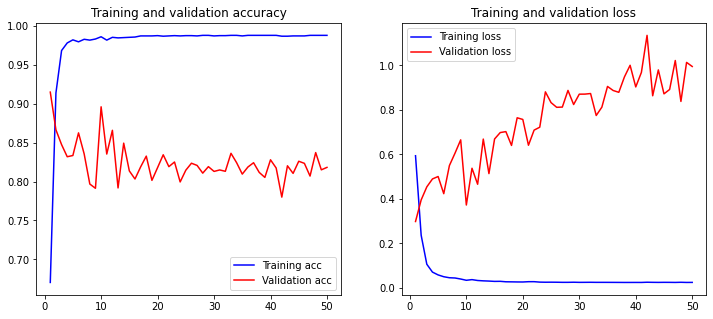

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

print('Recall   :', metrics.recall_score(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))


[[5076 1026]
 [ 131  130]]
Recall   : 0.49808429118773945
Accuracy : 0.8181675310388181


AUC: 0.6649713491336926


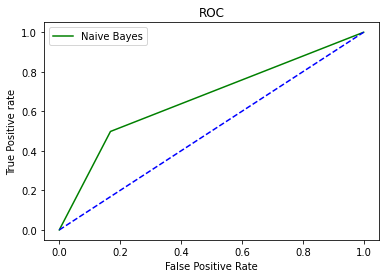

In [ ]:
plot_auc(y_test, y_pred)

In [ ]:
NN7 = model

## Assemble the 7 models as the final predictor for depression

### Transform test set

For each data entry, parse into each of the 7 symptom models; if >=4 out of 7 models return 1, label it as depression, otherwise, label as not depression

In [ ]:
df_test

,ID,AuthorID,Author,Date,Content,Words,symp_one,symp_two,symp_three,symp_four,symp_five,symp_six,symp_seven,None
12,13,3.030000e+17,Emma/Blue#2035,43630.88194,it‚äôs like take knife try stab cut nerve arm,17,0,0,0,0.0,0,0,0.0,1.0
15,16,4.840000e+17,Lucid_Thoughts#2342,43631.01458,minute ago thing feel like sharp pain,17,0,0,0,0.0,0,0,1.0,0.0
22,23,4.120000e+17,~‚òÖ~#0666,43631.43889,abusive family difficult violent help tell help,32,0,0,0,1.0,1,0,0.0,0.0
27,28,3.660000e+17,BasicCouple#7323,43631.45903,severely injure broken bone burn stab wound li...,63,0,0,0,1.0,0,1,1.0,0.0
32,33,3.030000e+17,Emma/Blue#2035,43631.625,don‚äôt reason say i‚äôm burden way help,28,0,0,1,1.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23959,23965,3.460000e+17,gogy~#2680,44070.52986,wanna kill literally push limit man not shit a...,15,0,0,0,0.0,0,0,1.0,0.0
23961,23967,2.290000e+17,alex.#5092,44070.75764,need bit help decision choice simple be give r...,27,0,0,0,0.0,0,0,0.0,1.0
23962,23968,5.320000e+17,BrielleBunnyüíç#8328,44070.90139,bad day try hard happy,16,0,0,0,0.0,0,0,0.0,1.0
23974,23980,3.210000e+17,cocosiz#2140,44071.11667,usually smoke weed amplify feel make anxious,19,0,0,0,1.0,0,0,0.0,0.0


In [ ]:
# add column to identify number of symptoms
df_test['num_symptoms'] = [0]*len(df_test)

for i in range(0,len(df_test)):
  df_test['num_symptoms'].iloc[i] = df_test['symp_one'].iloc[i] + df_test['symp_two'].iloc[i] + df_test['symp_three'].iloc[i] + df_test['symp_four'].iloc[i] + df_test['symp_five'].iloc[i] + df_test['symp_six'].iloc[i] + df_test['symp_seven'].iloc[i]

### Test different thresholds 1-7

In [ ]:
# add target column
y_valid1 = [1 if x >= 1 else 0 for x in df_test['num_symptoms']]
y_valid2 = [1 if x >= 2 else 0 for x in df_test['num_symptoms']]
y_valid3 = [1 if x >= 3 else 0 for x in df_test['num_symptoms']]
y_valid4 = [1 if x >= 4 else 0 for x in df_test['num_symptoms']]
y_valid5 = [1 if x >= 5 else 0 for x in df_test['num_symptoms']]

In [ ]:
X_valid = df_test['Content']

### Assemble the models

In [ ]:
def final_predictor1(X_valid):
  test_vec1=vectorizer_sym1.transform(X_valid.values).toarray()
  pred1 = RFCLF1.predict(test_vec1)
  test_vec2=vectorizer_sym2.transform(X_valid.values).toarray()
  pred2 = RFCLF2.predict(test_vec2)
  test_vec3=vectorizer_sym3.transform(X_valid.values).toarray()
  pred3 = RFCLF3.predict(test_vec3)
  test_vec4=vectorizer_sym4.transform(X_valid.values).toarray()
  pred4 = RFCLF4.predict(test_vec4)
  test_vec5=vectorizer_sym5.transform(X_valid.values).toarray()
  pred5 = RFCLF5.predict(test_vec5)
  test_vec6=vectorizer_sym6.transform(X_valid.values).toarray()
  pred6 = RFCLF6.predict(test_vec6)
  test_vec7=vectorizer_sym7.transform(X_valid.values).toarray()
  pred7 = RFCLF7.predict(test_vec7)
  
  arr = np.array([pred1, pred2, pred3, pred4, pred5, pred6, pred7])
  temp_preds = arr.sum(axis=0)
  preds = [1 if x >= 1 else 0 for x in temp_preds]
  return preds

In [ ]:
def final_predictor2(X_valid):
  test_vec1=vectorizer_sym1.transform(X_valid.values).toarray()
  pred1 = RFCLF1.predict(test_vec1)
  test_vec2=vectorizer_sym2.transform(X_valid.values).toarray()
  pred2 = RFCLF2.predict(test_vec2)
  test_vec3=vectorizer_sym3.transform(X_valid.values).toarray()
  pred3 = RFCLF3.predict(test_vec3)
  test_vec4=vectorizer_sym4.transform(X_valid.values).toarray()
  pred4 = RFCLF4.predict(test_vec4)
  test_vec5=vectorizer_sym5.transform(X_valid.values).toarray()
  pred5 = RFCLF5.predict(test_vec5)
  test_vec6=vectorizer_sym6.transform(X_valid.values).toarray()
  pred6 = RFCLF6.predict(test_vec6)
  test_vec7=vectorizer_sym7.transform(X_valid.values).toarray()
  pred7 = RFCLF7.predict(test_vec7)
  
  arr = np.array([pred1, pred2, pred3, pred4, pred5, pred6, pred7])
  temp_preds = arr.sum(axis=0)
  preds = [1 if x >= 2 else 0 for x in temp_preds]
  return preds

In [ ]:
def final_predictor3(X_valid):
  test_vec1=vectorizer_sym1.transform(X_valid.values).toarray()
  pred1 = RFCLF1.predict(test_vec1)
  test_vec2=vectorizer_sym2.transform(X_valid.values).toarray()
  pred2 = RFCLF2.predict(test_vec2)
  test_vec3=vectorizer_sym3.transform(X_valid.values).toarray()
  pred3 = RFCLF3.predict(test_vec3)
  test_vec4=vectorizer_sym4.transform(X_valid.values).toarray()
  pred4 = RFCLF4.predict(test_vec4)
  test_vec5=vectorizer_sym5.transform(X_valid.values).toarray()
  pred5 = RFCLF5.predict(test_vec5)
  test_vec6=vectorizer_sym6.transform(X_valid.values).toarray()
  pred6 = RFCLF6.predict(test_vec6)
  test_vec7=vectorizer_sym7.transform(X_valid.values).toarray()
  pred7 = RFCLF7.predict(test_vec7)
  
  arr = np.array([pred1, pred2, pred3, pred4, pred5, pred6, pred7])
  temp_preds = arr.sum(axis=0)
  preds = [1 if x >= 3 else 0 for x in temp_preds]
  return preds

In [ ]:
def final_predictor4(X_valid):
  test_vec1=vectorizer_sym1.transform(X_valid.values).toarray()
  pred1 = RFCLF1.predict(test_vec1)
  test_vec2=vectorizer_sym2.transform(X_valid.values).toarray()
  pred2 = RFCLF2.predict(test_vec2)
  test_vec3=vectorizer_sym3.transform(X_valid.values).toarray()
  pred3 = RFCLF3.predict(test_vec3)
  test_vec4=vectorizer_sym4.transform(X_valid.values).toarray()
  pred4 = RFCLF4.predict(test_vec4)
  test_vec5=vectorizer_sym5.transform(X_valid.values).toarray()
  pred5 = RFCLF5.predict(test_vec5)
  test_vec6=vectorizer_sym6.transform(X_valid.values).toarray()
  pred6 = RFCLF6.predict(test_vec6)
  test_vec7=vectorizer_sym7.transform(X_valid.values).toarray()
  pred7 = RFCLF7.predict(test_vec7)
  
  arr = np.array([pred1, pred2, pred3, pred4, pred5, pred6, pred7])
  temp_preds = arr.sum(axis=0)
  preds = [1 if x >= 4 else 0 for x in temp_preds]
  return preds

In [ ]:
def final_predictor5(X_valid):
  test_vec1=vectorizer_sym1.transform(X_valid.values).toarray()
  pred1 = RFCLF1.predict(test_vec1)
  test_vec2=vectorizer_sym2.transform(X_valid.values).toarray()
  pred2 = RFCLF2.predict(test_vec2)
  test_vec3=vectorizer_sym3.transform(X_valid.values).toarray()
  pred3 = RFCLF3.predict(test_vec3)
  test_vec4=vectorizer_sym4.transform(X_valid.values).toarray()
  pred4 = RFCLF4.predict(test_vec4)
  test_vec5=vectorizer_sym5.transform(X_valid.values).toarray()
  pred5 = RFCLF5.predict(test_vec5)
  test_vec6=vectorizer_sym6.transform(X_valid.values).toarray()
  pred6 = RFCLF6.predict(test_vec6)
  test_vec7=vectorizer_sym7.transform(X_valid.values).toarray()
  pred7 = RFCLF7.predict(test_vec7)
  
  arr = np.array([pred1, pred2, pred3, pred4, pred5, pred6, pred7])
  temp_preds = arr.sum(axis=0)
  preds = [1 if x >= 5 else 0 for x in temp_preds]
  return preds

In [ ]:
def final_predictor6(X_valid):
  test_vec1=vectorizer_sym1.transform(X_valid.values).toarray()
  pred1 = RFCLF1.predict(test_vec1)
  test_vec2=vectorizer_sym2.transform(X_valid.values).toarray()
  pred2 = RFCLF2.predict(test_vec2)
  test_vec3=vectorizer_sym3.transform(X_valid.values).toarray()
  pred3 = RFCLF3.predict(test_vec3)
  test_vec4=vectorizer_sym4.transform(X_valid.values).toarray()
  pred4 = RFCLF4.predict(test_vec4)
  test_vec5=vectorizer_sym5.transform(X_valid.values).toarray()
  pred5 = RFCLF5.predict(test_vec5)
  test_vec6=vectorizer_sym6.transform(X_valid.values).toarray()
  pred6 = RFCLF6.predict(test_vec6)
  test_vec7=vectorizer_sym7.transform(X_valid.values).toarray()
  pred7 = RFCLF7.predict(test_vec7)
  
  arr = np.array([pred1, pred2, pred3, pred4, pred5, pred6, pred7])
  temp_preds = arr.sum(axis=0)
  preds = [1 if x >= 6 else 0 for x in temp_preds]
  return preds

In [ ]:
def eval(y_valid, y_preds):
  confusionMatrix = confusion_matrix(y_valid, y_preds)
  print(confusionMatrix)
  print('Precision:', metrics.precision_score(y_valid, y_preds, pos_label=1))
  print('Recall   :', metrics.recall_score(y_valid, y_preds, pos_label=1))
  print('Accuracy :', metrics.accuracy_score(y_valid, y_preds))
  print('F1 score :', metrics.f1_score(y_valid, y_preds, pos_label=1))
  plot_auc(y_valid, y_preds)

In [ ]:
y_preds1 = final_predictor1(X_valid)
y_preds2 = final_predictor2(X_valid)
y_preds3 = final_predictor3(X_valid)
y_preds4 = final_predictor4(X_valid)
y_preds5 = final_predictor5(X_valid)

[[2045 1359]
 [ 422  970]]
Precision: 0.41648776298840706
Recall   : 0.6968390804597702
Accuracy : 0.6286488740617181
F1 score : 0.5213652244020424
AUC: 0.6488014438726583


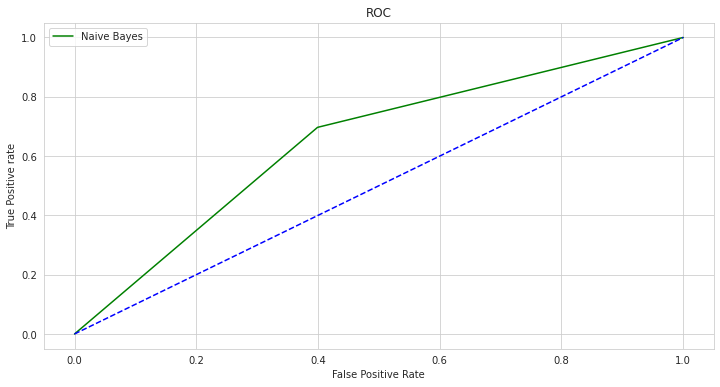

In [ ]:
eval(y_valid1, y_preds1)

[[3650  766]
 [ 206  174]]
Precision: 0.1851063829787234
Recall   : 0.45789473684210524
Accuracy : 0.7973311092577148
F1 score : 0.2636363636363636
AUC: 0.6422172959572845


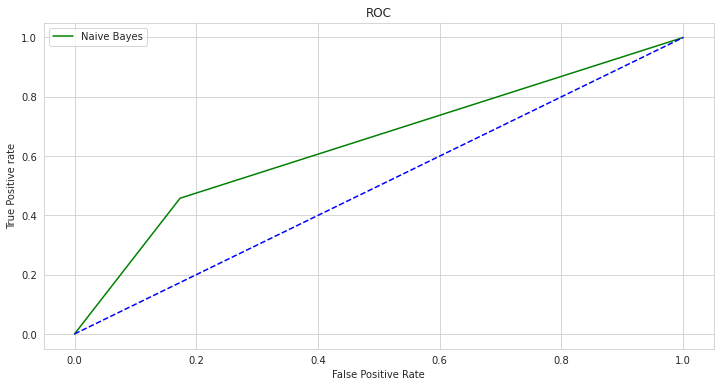

In [ ]:
eval(y_valid2, y_preds2)

[[4409  293]
 [  55   39]]
Precision: 0.11746987951807229
Recall   : 0.4148936170212766
Accuracy : 0.9274395329441201
F1 score : 0.18309859154929578
AUC: 0.6762898540231861


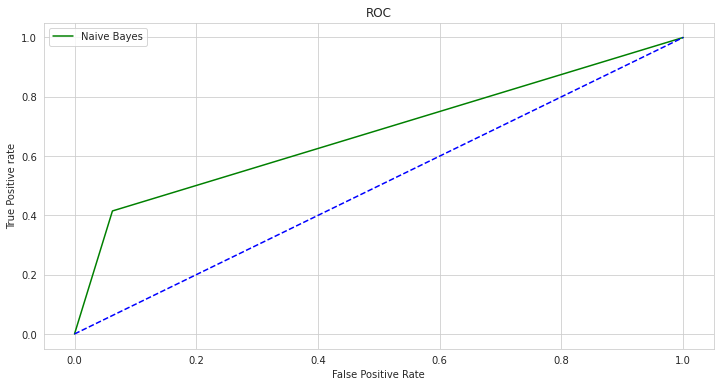

In [ ]:
eval(y_valid3, y_preds3)

[[4666  104]
 [  18    8]]
Precision: 0.07142857142857142
Recall   : 0.3076923076923077
Accuracy : 0.9745621351125938
F1 score : 0.11594202898550726
AUC: 0.6429446863409128


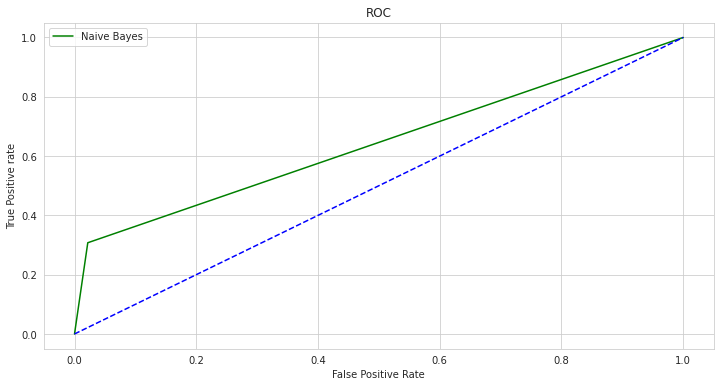

In [ ]:
eval(y_valid4, y_preds4)

[[4772   20]
 [   2    2]]
Precision: 0.09090909090909091
Recall   : 0.5
Accuracy : 0.9954128440366973
F1 score : 0.15384615384615385
AUC: 0.7479131886477463


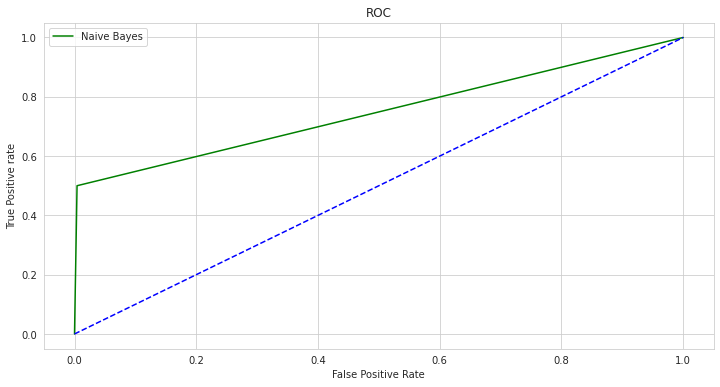

In [ ]:
eval(y_valid5, y_preds5)